#SOME NICE IMPORTS

In [837]:
import networkx as nx # useful for network operations
import re # regular expressions for text parsing and finding proper names
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
import nltk # useful for sentence parsing

#PATH DECLARATION

To save some time later and make it easier to reach folders

In [838]:
import os

PATH = os.getcwd()
print(PATH)


stats_path = os.path.join(PATH, 'results')
if not os.path.exists(stats_path):
    os.makedirs(stats_path)

save_path = os.path.join(os.getcwd(), "plots")
print(save_path)

os.makedirs(save_path, exist_ok=True)

/home/enrico/Documents/UNI/performance/EpidemicBroadcast/results
/home/enrico/Documents/UNI/performance/EpidemicBroadcast/results/plots


#PARSE FUNCTIONS

Functions to parse the output files into structures

In [839]:
#DESCRIPTION
#   Parse .vec file into lists
#INPUT
#   path of the text to parse
#RETURNS
#   user_couples_collisions : list of tuples with omnet id and node id for collisions
#   user_couples_coverage : list of tuples with omnet id and node id for status
#   users_actions : list with all the actions per omnet id

def parse_file_vec(filepath):
  text = []
  with open(filepath, "r", encoding='utf-8') as input_f:
      text = input_f.read()

  user_couples_collisions = re.findall(r'vector\s(\d+)\sFloor\.user\[(\d+)\]\scollisionStat', text)
  user_couples_coverage = re.findall(r'vector\s(\d+)\sFloor\.user\[(\d+)\]\scoverageVectorStat', text)
  users_actions = re.findall(r'([0-9]+)\t([0-9]+)\t([0-9]+)\t([0-9]+)', text)

  return user_couples_collisions, user_couples_coverage, users_actions


In [840]:
#DESCRIPTION
#   Parse .sca file into lists
#INPUT
#   path of the text to parse
#RETURNS
#   user_list : list with (id_user, x, y)
#   radius
#   max_message
#   window
#   coverage_percentage
#   producer_index
#   sim_time

def parse_file_sca(filepath):
  text = []
  with open(filepath, "r", encoding='utf-8') as input_f:
      text = input_f.read()

  pattern = r"par Floor\.user\[(\d+)\] coordX ([\d.]+)\npar Floor\.user\[\d+\] coordY ([\d.]+)"
  matches = re.findall(pattern, text)

  radius = re.findall(r'itervar\sR\s(\d+)', text)
  max_message = re.findall(r'itervar\sR\s(\d+)', text)
  window = re.findall(r'itervar\sW\s(\d+)', text)
  producer_index = re.findall(r'producerIndex\s(\d+)', text)
  sim_time = re.findall(r'simTimeEndStat:last\s(\d+)', text)
  coverage_sum = re.findall(r'coverageSum:sum\s(\d+)', text)
  collision_sum = re.findall(r'collisionSum:sum\s(\d+)', text)
  user_num = re.findall(r'par\sFloor\suserNumber\s(\d+)', text)

  user_list = [[int(match[0]), float(match[1]), float(match[2])] for match in matches]
  return user_list, int(radius[0]), int(user_num[0]),  int(producer_index[0]), int(sim_time[0]), int(coverage_sum[0]), int(collision_sum[0])

In [841]:
#DESCRIPTION
#   Parse .sca file into lists
#INPUT
#   path of the text to parse
#RETURNS
#   user_list : list with (id_user, x, y)
#   radius
#   max_message
#   window
#   coverage_percentage
#   producer_index
#   sim_time

def parse_file_sca_base(filepath):
  text = []
  with open(filepath, "r", encoding='utf-8') as input_f:
      text = input_f.read()

  pattern = r"par Floor\.user\[(\d+)\] coordX ([\d.]+)\npar Floor\.user\[\d+\] coordY ([\d.]+)"
  matches = re.findall(pattern, text)

  radius = re.findall(r'itervar\sR\s(\d+)', text)
  max_message = re.findall(r'itervar\sM\s(\d+)', text)
  window = re.findall(r'itervar\sW\s(\d+)', text)
  producer_index = re.findall(r'producerIndex\s(\d+)', text)
  sim_time = re.findall(r'simTimeEndStat:last\s(\d+)', text)
  coverage_sum = re.findall(r'coverageSum:sum\s(\d+)', text)
  collision_sum = re.findall(r'collisionSum:sum\s(\d+)', text)
  user_num = re.findall(r'par\sFloor\suserNumber\s(\d+)', text)

  user_list = [[int(match[0]), float(match[1]), float(match[2])] for match in matches]
  return user_list, int(radius[0]), int(user_num[0]), int(max_message[0]), int(window[0]), int(producer_index[0]), int(sim_time[0]), int(coverage_sum[0]), int(collision_sum[0])

In [842]:
#DESCRIPTION
#   Parse .sca file into lists [ONLY FOR midDens2kr_radius]
#INPUT
#   path of the text to parse
#RETURNS
#   user_list : list with (id_user, x, y)
#   radius
#   coverage_percentage
#   producer_index
#   sim_time

def parse_file_sca_rad(filepath):
  text = []
  with open(filepath, "r", encoding='utf-8') as input_f:
      text = input_f.read()

  pattern = r"par Floor\.user\[(\d+)\] coordX ([\d.]+)\npar Floor\.user\[\d+\] coordY ([\d.]+)"
  matches = re.findall(pattern, text)

  radius = re.findall(r'itervar\sR\s(\d+)', text)
  producer_index = re.findall(r'producerIndex\s(\d+)', text)
  sim_time = re.findall(r'simTimeEndStat:last\s(\d+)', text)
  coverage_sum = re.findall(r'coverageSum:sum\s(\d+)', text)
  collision_sum = re.findall(r'collisionSum:sum\s(\d+)', text)
  user_num = re.findall(r'par\sFloor\suserNumber\s(\d+)', text)

  user_list = [[int(match[0]), float(match[1]), float(match[2])] for match in matches]

    #simtime restituisce il time broadcast
  return user_list, int(radius[0]), int(user_num[0]), int(producer_index[0]), int(sim_time[0]), int(coverage_sum[0]), int(collision_sum[0])

In [843]:
#DESCRIPTION
#   Convert parsed lists into dict per user
#INPUT
#   list parsed and list of key tuples
#RETURNS
#   result dict

def convert_to_dict(dataset, new_keys):
  result_dict = {}
  # Create a mapping from old keys to new keys
  key_mapping = {int(old_key): int(new_key) for old_key, new_key in new_keys}

  for old_key, new_key in new_keys:
    result_dict[int(new_key)] = []

  for item in dataset:
    old_key = int(item[0])

    if old_key not in key_mapping:
      continue

    new_key = key_mapping[old_key]
    value = list(map(int, item[2:]))
    result_dict[new_key].append(value)

  return result_dict

In [844]:
#DESCRIPTION
#   Convert dict per user into generic list
#INPUT
#   dict
#RETURNS
#   result list

def get_generic_list(input_dict):
  list_without_keys = list(input_dict.values())
  return list_without_keys

In [845]:
#DESCRIPTION
#   Flattens list by one level (es: from lists of list to list)
#INPUT
#   input_list
#RETURNS
#   flattened list

def flatten_list(input_list):
  flattened_list = [item for sublist in input_list for item in sublist]
  return flattened_list

In [846]:
#DESCRIPTION
#   Given a list, keeps only second element
#INPUT
#   input_list
#RETURNS
#   new list
def extract_second_elements(lst):
    return [sub[1] for sub in lst]

In [847]:
#DESCRIPTION
#   Given the raw data parsed from the vec, it processes it
#INPUT
#   data, users
#RETURNS
#   new list

def process_data_vec(data, users):
    dict_data = convert_to_dict(data, users)
    return dict_data

In [848]:
#DESCRIPTION
#   Parses all the vec files in a folder and returns a list of lists with all
#   the collisions and coverages
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#RETURNS
#   collisions lists
#   coverage lists

def parse_all_files_vec(folder_path, repetitions, different_configs):
  collisions = []
  coverage = []

  for i in range(different_configs):
    conf_collisions = []
    conf_coverage = []

    for j in range(repetitions):
      index = i*repetitions + j
      #print("index: " + str(index))
      file_name = str(index) + ".vec"
      file_path = os.path.join(folder_path, file_name)

      user_couples_collisions, user_couples_coverage, users_actions = parse_file_vec(file_path)
      current_collisions = process_data_vec(users_actions, user_couples_collisions)
      current_coverage = process_data_vec(users_actions, user_couples_coverage)

      conf_collisions.append(current_collisions)
      conf_coverage.append(current_coverage)

    collisions.append(conf_collisions)
    coverage.append(conf_coverage)


  return collisions, coverage

In [849]:
#DESCRIPTION
#   Parses all the sca files in a folder and returns a list of lists with all
#   the collisions and coverages
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#RETURNS
#   collisions lists
#   coverage lists

def parse_all_files_sca(folder_path, repetitions, numconfigs):
  collisions = []
  coverage = []
  radius_list = []   
  sim_time_list = []
  users = []

  for i in range(numconfigs):
    conf_collisions = []
    conf_coverage = []
    conf_radius = []
    conf_time = []
    conf_users = []

    for j in range(repetitions):
      index = i*repetitions + j
      file_name = str(index) + ".sca"
      file_path = os.path.join(folder_path, file_name)

      user_list, radius, user_num, producer_index, sim_time, coverage_sum, collision_sum = parse_file_sca(file_path)

      conf_collisions.append(collision_sum)
      conf_coverage.append(coverage_sum/user_num)
      conf_radius.append(radius)
      conf_time.append(sim_time)
      conf_users.append(user_list)

    collisions.append(conf_collisions)
    coverage.append(conf_coverage)
    radius_list.append(conf_radius)
    sim_time_list.append(conf_time)
    users.append(conf_users)


  return collisions, coverage, users, radius_list, sim_time_list

In [850]:
#DESCRIPTION
#   Parses all the sca files in a folder and returns a list of lists with all
#   the collisions and coverages
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#RETURNS
#   collisions lists
#   coverage lists

def parse_all_files_sca_bases(folder_path, repetitions, parameters):
  collisions = []
  coverage = []
  rad = []
  time

  for i in range(pow(2, parameters)):
    conf_collisions = []
    conf_coverage = []
    conf_radius = []

    for j in range(repetitions):
      index = i*repetitions + j
      file_name = str(index) + ".sca"
      file_path = os.path.join(folder_path, file_name)

      user_list, radius, user_num, max_message, window, producer_index, sim_time, coverage_sum, collision_sum = parse_file_sca_base(file_path)

      conf_collisions.append(collision_sum)
      conf_coverage.append(coverage_sum/user_num)
      conf_radius.append(radius)
      

    collisions.append(conf_collisions)
    coverage.append(conf_coverage)
    rad.append(conf_radius)

  return collisions, coverage, rad

In [851]:
#DESCRIPTION
#   Parse .sca file into lists
#INPUT
#   path of the text to parse
#RETURNS
#   user_list : list with (id_user, x, y)
#   radius
#   max_message
#   window
#   coverage_percentage
#   producer_index
#   sim_time

def parse_file_sca_step_msg(filepath):
  text = []
  with open(filepath, "r", encoding='utf-8') as input_f:
      text = input_f.read()

  pattern = r"par Floor\.user\[(\d+)\] coordX ([\d.]+)\npar Floor\.user\[\d+\] coordY ([\d.]+)"
  matches = re.findall(pattern, text)

  radius = re.findall(r'itervar\sR\s(\d+)', text)
  max_message = re.findall(r'itervar\sM\s(\d+)', text)
  window = re.findall(r'itervar\sW\s(\d+)', text)
  producer_index = re.findall(r'producerIndex\s(\d+)', text)
  sim_time = re.findall(r'simTimeEndStat:last\s(\d+)', text)
  coverage_sum = re.findall(r'coverageSum:sum\s(\d+)', text)
  collision_sum = re.findall(r'collisionSum:sum\s(\d+)', text)
  user_num = re.findall(r'par\sFloor\suserNumber\s(\d+)', text)

  user_list = [[int(match[0]), float(match[1]), float(match[2])] for match in matches]
  return user_list, int(radius[0]), int(user_num[0]), int(max_message[0]),  int(producer_index[0]), int(sim_time[0]), int(coverage_sum[0]), int(collision_sum[0])

#DESCRIPTION
#   Parses all the sca files in a folder and returns a list of lists with all
#   the collisions and coverages
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#RETURNS
#   collisions lists
#   coverage lists

def parse_all_files_sca_step_msg(folder_path, repetitions, nConfigs):

  collisions = []
  coverage = []
  radius_list = []
  time = []
  max_messages = []

  for i in range(nConfigs):
    conf_collisions = []
    conf_coverage = []
    conf_radius = []
    conf_messages = []
    conf_time = []

    for j in range(repetitions):
      index = i*repetitions + j
      file_name = str(index) + ".sca"
      file_path = os.path.join(folder_path, file_name)

      user_list, radius, user_num, max_message, producer_index, sim_time, coverage_sum, collision_sum = parse_file_sca_step_msg(file_path)

      conf_collisions.append(collision_sum)
      conf_coverage.append(coverage_sum/user_num)
      conf_radius.append(radius)
      conf_time.append(sim_time)
      conf_messages.append(max_message)

    collisions.append(conf_collisions)
    coverage.append(conf_coverage)
    radius_list.append(conf_radius)
    time.append(conf_time)
    max_messages.append(conf_messages)

  return collisions, coverage, radius_list, time, max_messages

#STATISTICS FUNCTIONS

##Functions for 2kr

every function is a step of the 2kr, creating every row/column

In [852]:
import itertools

#DESCRIPTION
# Given a list, returns the list exteded with all the possible combinations
# of the elements
#INPUT
#   list
#RETURNS
#   extended list

def extend_list(input_list):
  result = []
  length = len(input_list)

  # Copies list in result
  for i in range(length):
      result.append(input_list[i])

  # Generate combinations of products of pairs, triples, etc.
  for r in range(2, length + 1):
      combinations = itertools.combinations(input_list, r)
      for combo in combinations:
          product = 1
          for num in combo:
              product *= num
          result.append(product)

  return result

In [853]:
#DESCRIPTION
# Given the number of parameters, returns the intial matrix of 1s for the 2kr
#INPUT
#   k: number of parameters
#RETURNS
#   matrix of -1 and 1

from itertools import product

def generate_1s_matrix(k):
  levels = [-1, 1]
  combinations_flipped = list(product(levels, repeat=k))
  combinations_flipped_as_lists = [list(combo) for combo in combinations_flipped]
  combinations_list = [row[::-1] for row in combinations_flipped_as_lists]
  return combinations_list

In [854]:
#DESCRIPTION
# Given the number of parameters, returns the full matrix of 1s for the 2kr
#INPUT
#   k: number of parameters
#RETURNS
#   matrix of -1 and 1

def save_matrix_to_txt(matrix, filename):
    with open(filename, 'w') as file:
        for row in matrix:
            file.write('\t'.join(map(str, row)) + '\n')



def generate_2kr_full_matrix(k):
    initial_matrix = generate_1s_matrix(k)
    new_list = []
    for row in initial_matrix:
        new_row = extend_list(row)
        new_list.append(new_row)

    modified_matrix = [[1] + row for row in new_list]
    return modified_matrix



In [855]:
import math

def scalar_product(matrix, input_list):
  matrix_array = np.array(matrix)
  input_array = np.array(input_list)

  transposed_matrix = matrix_array.T
  products = np.dot(transposed_matrix, input_array)
  return products


def get_mean_qi(sums, k):
  sums_array = np.array(sums)
  divisor = pow(2, k)
  result = np.divide(sums_array, divisor)
  return result
        
    
def get_mean_row(matrix):
    averages = [sum(sublist) / len(sublist) if sublist else 0 for sublist in matrix]
    return averages


def get_k_qi2(sums, mean):
  sums_array = np.array(sums)
  mean_array = np.array(mean)

  result = result = np.multiply(sums_array, mean_array)
  return result


def get_error_matrix(matrix):
    averages = get_mean_row(matrix)
    result = []
    for sublist, avg in zip(matrix, averages):
        subtracted = [val - avg for val in sublist]
        result.append(subtracted)
    return result


def get_sse(error_matrix):
    sse = sum(val ** 2 for sublist in error_matrix for val in sublist)
    return sse

def get_percentages(combinations, sse):
  # Remove the first element of combinations
  combinations = combinations[1:]

  # Get the sum of all elements in combinations plus sse
  total_sum = sum(combinations) + sse

  # Calculate the percentages
  combinations_percentage = combinations / total_sum
  sse_percentage = sse / total_sum
  return combinations_percentage, sse_percentage


def convert_to_log(list_of_lists):
    return [[math.log(x) for x in sublist if x > 0] for sublist in list_of_lists]


In [4]:
def test_finite_variance(data, save_output):
    avg_response = get_mean_row(data)
    error_matrix = get_error_matrix(data)
    predicted_response = []


    for i, sublist in enumerate(error_matrix):
        n_errors = len(sublist)
        predicted_response.extend([avg_response[i] for _ in range(n_errors)])
    
    residuals = [item for sublist in error_matrix for item in sublist]

    print("avg_response ",avg_response)

    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predicted_response, y=residuals, palette='viridis')

    # Add labels and title
    plt.xlabel('Predicted Response')
    plt.ylabel('Residuals')

    # Show the plot
    plt.savefig(save_output, dpi=300)
    plt.show()

In [3]:
def test_independence(data, save_output, threshold = 0):
    error_matrix = get_error_matrix(data)
    predicted_response = []
    
    residuals = [item for sublist in error_matrix for item in sublist]
    run_index = list(range(1, len(residuals)+1))
    
    if(threshold != 0):
        filtered_indices = [i for i, val in enumerate(residuals) if val >= threshold or val <= -threshold]
        residuals = [val for i, val in enumerate(residuals) if i not in filtered_indices]
        run_index = [val for i, val in enumerate(run_index) if i not in filtered_indices]

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=run_index, y=residuals, palette='viridis')

    # Add labels and title
    plt.xlabel('Run Number')
    plt.ylabel('Residuals')

    # Show the plot
    plt.savefig(save_output)
    plt.show()

## Actual 2kr

In [856]:
def factorial_2kr(data, parameters, iterations, output_file):
    
    mean_data = get_mean_row(data)
    print("mean_data")
    print(mean_data) 

    factorial_matrix = generate_2kr_full_matrix(parameters)
    print("Factorial Matrix", factorial_matrix)  #-1 and +1 matrix, to be printed
    sums = scalar_product(factorial_matrix, mean_data)
    print(sums)  # to be printed
    mean_qi = get_mean_qi(sums, parameters)
    print(mean_qi)  # to be printed

    error_matrix = get_error_matrix(data)
    sse = get_sse(error_matrix)  # to be printed

    qi_final = iterations * get_k_qi2(sums, mean_qi)  # to be printed

    print("qi_final: ", qi_final)
    print("sse: ", sse)

    percentages, percentage_sse = get_percentages(qi_final, sse)  # both to be printed

    data_to_print = [mean_data, factorial_matrix, sums, mean_qi, sse, qi_final, percentages, percentage_sse]
    print_to_file(data_to_print, output_file)

    return percentages, percentage_sse


def print_to_file(data, file_path):
    title = file_path.split("/")[10]
    with open(file_path, 'w') as file:
        file.write(title+'\n\n')
        file.write("Mean Data:\n")
        for value in data[0]:
            file.write(f"{value}\n")
        file.write("\n")

        file.write("Factorial Matrix:\n")
        for row in data[1]:
            file.write(" ".join(map(str, row)) + "\n")
        file.write("\n")

        file.write("Sums:\n")
        for value in data[2]:
            file.write(f"{value}\n")
        file.write("\n")

        file.write("Mean Qi:\n")
        for value in data[3]:
            file.write(f"{value}\n")
        file.write("\n")

        file.write(f"SSE: \n{data[4]}\n\n")
        file.write(f"Qi Final:\n")
        for value in data[5]:
            file.write(f"{value}\n")
        file.write("\n")


        file.write("Percentages:\n")
        for value in data[6]:
            file.write(f"{value}\n")
        file.write("\n")

        file.write(f"Percentage SSE: {data[7]}\n\n")


##Functions for printing results nicely

In [857]:
#DESCRIPTION
# Given a list, returns the list exteded with all the possible combinations
# of the elements
#INPUT
#   list
#RETURNS
#   extended list

def extend_list_strings(input_list):
    result = []
    length = len(input_list)

    # Copies list in result
    for i in range(length):
        result.append(input_list[i])

    # Generate combinations of products of pairs, triples, etc.
    for r in range(2, length + 1):
        combinations = itertools.combinations(input_list, r)
        for combo in combinations:
            concatenated = '-'.join(combo)
            result.append(concatenated)

    return result

In [858]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(data, output_path, bins=6):
    # Create a histogram using Seaborn
    plt.figure(figsize=(8, 6))
    sns.histplot(data, bins=bins, kde=False, color='skyblue')
    
    # Set labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Save or display the plot
    plt.savefig(output_path)
    plt.show()



In [859]:
#DESCRIPTION
# Given a list of lists, returns the list without the values under the threshold
#INPUT
#   list of lists
#RETURNS
#   modified list of lists

def remove_values_under_threshold(list_of_lists, threshold=0.5):
    cleaned_data = []
    for sublist in list_of_lists:
        cleaned_sublist = [x for x in sublist if x >= threshold]
        cleaned_data.append(cleaned_sublist)
    return cleaned_data

#FUNCTIONS FOR ANALYSIS OF DISTANCE

In [860]:
#DESCRIPTION
# two users, returns the distance between them
def euclidean_distance(user1, user2):
    return np.sqrt((user1[1] - user2[1])**2 + (user1[2] - user2[2])**2)

In [861]:
#DESCRIPTION
#Produces a list with lists [user, distance, collisions]
#INPUTS
#users: dict of users
#dict_metric : collision dict
#base_counter : counter for ids to avoid repetitions
def distance_collisions_list(users, dict_metric, base_counter):
    starter = users[0]
    
    distance_metric_list = []
    for user in users[1:]:
        if user[0] not in dict_metric:
            current_distance = euclidean_distance(user, starter)
            distance_metric_list.append([user[0] + base_counter, current_distance, 0])
            continue
        current_distance = euclidean_distance(user, starter)
        for dict_entry in dict_metric[user[0]]:
            distance_metric_list.append([user[0] + base_counter, current_distance, dict_entry[1]])
    return distance_metric_list

#CODE FOR 2KR RESULTS PRINTED

In [862]:
#insert you parameters
name_run = "midDens2kr"
repetitions = 50
parameters = 3
different_configs = pow(2, parameters)
parameter_names = ["Radius", "MaxMessage", "Window"]
parameter_names_full = extend_list_strings(parameter_names)

#parsing
folder_path = os.path.join(stats_path, 'basic')
folder_path = os.path.join(folder_path, name_run)
collisions, coverages, users, radius, times = parse_all_files_sca(folder_path, repetitions, different_configs)

coverages = remove_values_under_threshold(coverages, 0.5)

conf_path = os.path.join(save_path, "basic", name_run)

#factorial 2kr
perc_collisions, perc_sse_collisions = factorial_2kr(collisions, parameters, repetitions, os.path.join(conf_path, "collisions_.txt"))
perc_coverages, perc_sse_coverages = factorial_2kr(coverages, parameters, repetitions, os.path.join(conf_path, "coverages_.txt"))
perc_times, perc_sse_times = factorial_2kr(times, parameters, repetitions, os.path.join(conf_path, "time.txt"))

#prints
print("\nRESULTS OF RUN ", name_run, " WITH ", repetitions, " repetitions\n")

print("COLLISIONS")
for i in range(len(parameter_names_full)):
  print(parameter_names_full[i], ": ", perc_collisions[i])
print("ERROR: ", perc_sse_collisions, "\n")

print("COVERAGE")
for i in range(len(parameter_names_full)):
  print(parameter_names_full[i], ": ", perc_coverages[i])
print("ERROR: ", perc_sse_coverages, "\n")

print("TIMES")
for i in range(len(parameter_names_full)):
  print(parameter_names_full[i], ": ", perc_times[i])
print("ERROR: ", perc_sse_times, "\n")

mean_data
[207.24, 2918.54, 370.36, 7621.02, 76.16, 888.7, 106.6, 2191.82]
Factorial Matrix [[1, -1, -1, -1, 1, 1, 1, -1], [1, 1, -1, -1, -1, -1, 1, 1], [1, -1, 1, -1, -1, 1, -1, 1], [1, 1, 1, -1, 1, -1, -1, -1], [1, -1, -1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, 1, -1, -1], [1, -1, 1, 1, -1, -1, 1, -1], [1, 1, 1, 1, 1, 1, 1, 1]]
[14380.44 12859.72  6199.16 -7853.88  5812.04 -7064.2  -3532.04 -3266.68]
[1797.555 1607.465  774.895 -981.735  726.505 -883.025 -441.505 -408.335]
qi_final:  [1.29248159e+09 1.03357749e+09 2.40184904e+08 3.85521444e+08
 2.11123806e+08 3.11893260e+08 7.79706660e+07 6.66949889e+07]
sse:  41434966.640000015
mean_data
[0.7938257575757577, 0.967675, 0.9303989361702125, 0.9910000000000001, 0.8923333333333333, 0.9920500000000001, 0.947472222222222, 0.9995499999999999]
Factorial Matrix [[1, -1, -1, -1, 1, 1, 1, -1], [1, 1, -1, -1, -1, -1, 1, 1], [1, -1, 1, -1, -1, 1, -1, 1], [1, 1, 1, -1, 1, -1, -1, -1], [1, -1, -1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, 1, -1, -1], [1, -1

#FUNCTIONS FOR ANALYSIS OF DISTANCE

In [863]:
#DESCRIPTION
# two users, returns the distance between them
def euclidean_distance(user1, user2):
    return np.sqrt((user1[1] - user2[1])**2 + (user1[2] - user2[2])**2)

In [864]:
#DESCRIPTION
#Produces a list with pairs [distance, coverage]
#coverage = 0 if not reached, 1 if relayed, 2 if reached but not relayed
#INPUTS
#users: dict of users, coverage dict
def distance_coverage_list(users, dict_metric):
    starter = users[0]
    
    distance_metric_list = []
    for user in users[1:]:
        if user[0] not in dict_metric:
            current_distance = euclidean_distance(user, starter)
            distance_metric_list.append([current_distance, 0])
            continue
        current_distance = euclidean_distance(user, starter)
        for dict_entry in dict_metric[user[0]]:
            if dict_entry[1] == 0:
                continue
            distance_metric_list.append([current_distance, dict_entry[1]])
    return distance_metric_list
        

In [865]:
#DESCRIPTION
#Produces a list with lists [user, distance, collisions]
#INPUTS
#users: dict of users
#dict_metric : collision dict
#base_counter : counter for ids to avoid repetitions
def distance_collisions_list(users, dict_metric, base_counter):
    starter = users[0]
    
    distance_metric_list = []
    for user in users[1:]:
        if user[0] not in dict_metric:
            current_distance = euclidean_distance(user, starter)
            distance_metric_list.append([user[0] + base_counter, current_distance, 0])
            continue
        current_distance = euclidean_distance(user, starter)
        for dict_entry in dict_metric[user[0]]:
            distance_metric_list.append([user[0] + base_counter, current_distance, dict_entry[1]])
    return distance_metric_list

In [866]:
def plot_with_confidence_interval(x_values, y_mean, y_ci, color, marker, y_label, title, save_path):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(x_values, y_mean, yerr=y_ci, color=color, marker=marker, label=y_label)
    ax.set_xlabel('Radius')
    ax.set_ylabel(y_label, color=color)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


# DESCRIPTION
#   This function generates various plots and calculates statistics for a simulation scenario,
#   including mean collisions, mean coverages, and mean time with respect to different radius values.
# INPUT
#   path: Folder name containing simulation data files.
#   repetitions: Number of repetitions for each configuration.
#   nConfigs: Number of different configurations.
# RETURNS
#   None

import os
import numpy as np
import matplotlib.pyplot as plt

def print_graph_radius(path, repetitions, nConfigs):
    # Define the parameter names for the plot.
    parameter_names = ["Radius"]
    parameter_names_full = extend_list_strings(parameter_names)

    # Parsing simulation data files.
    folder_path = os.path.join(stats_path, path)
    print(folder_path)
    
    collisions, coverages, users, radius, sim_time = parse_all_files_sca(folder_path, repetitions, nConfigs)

    # Add mean for coverage values below a certain threshold.


    radius_values = [sublist[0] for sublist in radius]
    

    for i in range(len(radius_values)):

        print(f"Radius: {radius_values[i]}")
        print(f"Collisions: {collisions[i]}")
        print(f"Coverages: {coverages[i]}")
        print("-----------------------")
    
    

    # Create a directory to save the generated plots and statistical information.
    conf_path = os.path.join(save_path, path)
    os.makedirs(conf_path, exist_ok=True)

    # Example of descriptive analysis and visualization.
    mean_collisions = np.mean(collisions, axis=1)
    mean_coverages = get_mean_row(coverages)
    mean_time = np.mean(sim_time, axis=1)

    # Radius values from 1 to 30.

    # Calculate confidence intervals for collisions, time, and coverages.
    ci_collisions = 1.96 * np.std(collisions, axis=1) / np.sqrt(repetitions)
    ci_time = 1.96 * np.std(sim_time, axis=1) / np.sqrt(repetitions)
    ci_coverages = [1.96 * np.std(row) / np.sqrt(repetitions) for row in coverages]

    ci_coverages = np.array(ci_coverages)

    # Display basic statistics.
    print("Basic Statistics:")
    print("Mean Collisions:", np.mean(mean_collisions))
    print("Mean Coverages:", np.mean(mean_coverages))
    print("Mean Time:", np.mean(mean_time))
    print()

    # Display percentiles.
    print("Percentiles:")
    print("25th Percentile Collisions:", np.percentile(mean_collisions, 25))
    print("50th Percentile (Median) Collisions:", np.percentile(mean_collisions, 50))
    print("75th Percentile Collisions:", np.percentile(mean_collisions, 75))
    print()

    # Display confidence interval information.
    print("Confidence Intervals:")
    for i, rad in enumerate(radius_values):
        print(f"\nRadius {rad}:")

        # Mean Collisions
        ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
        print(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]")

        # Mean Coverages
        ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
        print(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]")

        # Mean Time
        ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
        print(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]")

    # Save confidence interval information to a text file.
    with open(os.path.join(conf_path, "confidence_intervals.txt"), 'w') as file:
        file.write("Confidence Intervals:\n")
        file.write("Confidence Level: 95%\n\n")  # Add the confidence level information

        for i, rad in enumerate(radius_values):
            file.write(f"\nRadius {rad}:\n")

            # Mean Collisions
            ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
            file.write(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]\n")

            # Mean Coverages
            ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
            file.write(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]\n")

            # Mean Time
            ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
            file.write(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]\n")

    # Create and save the first set of axes plot (Mean Collisions, Mean Coverages, and Mean Time vs. Radius).
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(radius_values, mean_collisions, color='blue', marker='o', label='Mean Collisions')
    ax1.set_xlabel('Radius')
    ax1.set_ylabel('Mean Collisions', color='blue')
    ax1.set_title('Mean Collisions, Mean Coverages & Mean Time / Radius')

    # Create the second set of axes (ax2) with the same x-axis scale as ax1
    ax2 = ax1.twinx()
    ax2.plot(radius_values, mean_coverages, color='green', marker='s', label='Mean Coverages')
    ax2.set_ylabel('Mean Coverages', color='green')
    
    # Set y-axis limits to be between 0 and 1
    ax2.set_ylim(0, 1)
    
    # Optionally, you can set ticks to show specific values if needed
    ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])

    # Create the third set of axes (ax3) with an independent y-axis scale
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Move the right spine to the right
    ax3.plot(radius_values, mean_time, color='red', marker='^', label='Mean Time')
    ax3.set_ylabel('Mean Time', color='red')

    # Automatically adjust layout to avoid overlap
    plt.tight_layout()

    # Save the first plot
    plt.savefig(os.path.join(conf_path, "COLLISIONS-COVERAGES-TIME"))
    plt.show()

    # Create and save the second plot (Mean Coverages vs. Radius and Mean Collisions vs. Radius).
    fig, ax4 = plt.subplots(figsize=(10, 6))
    ax4.plot(radius_values, mean_coverages, color='green', marker='s', label='Mean Coverages')
    ax4.set_xlabel('Radius')
    ax4.set_ylabel('Mean Coverages', color='green')
    ax4.set_title('Mean Coverages & Mean Collisions / Radius')

    ax5 = ax4.twinx()
    ax5.plot(radius_values, mean_collisions, color='blue', marker='o', label='Mean Collisions')
    ax5.set_ylabel('Mean Collisions', color='blue')

    # Automatically adjust layout to avoid overlap
    plt.tight_layout()

    # Save the second plot
    plt.savefig(os.path.join(conf_path, "COVERAGES-COLLISIONS-RADIUS"))
    plt.show()

    # Create and save the third plot (Mean Coverages vs. Time and Radius).
    fig, ax6 = plt.subplots(figsize=(10, 6))
    ax6.plot(radius_values, mean_coverages, color='green', marker='s', label='Mean Coverages')
    ax6.set_xlabel('Radius')
    ax6.set_ylabel('Mean Coverages', color='green')
    ax6.set_title('Mean Coverages & Mean Time / Radius')

    ax7 = ax6.twinx()
    ax7.plot(radius_values, mean_time, color='red', marker='^', label='Mean Time')
    ax7.set_ylabel('Mean Time', color='red')

    # Automatically adjust layout to avoid overlap
    plt.tight_layout()

    # Save the third plot
    plt.savefig(os.path.join(conf_path, "COVERAGES-TIME-RADIUS"))
    plt.show()

    # Create and save the fourth plot (Mean Collisions vs. Radius with confidence intervals).
    plot_with_confidence_interval(radius_values, mean_collisions, ci_collisions, 'blue', 'o', 'Mean Collisions',
                                  'Mean Collisions with Confidence Interval',
                                  os.path.join(conf_path, "COLLISIONS-CI-RADIUS"))

    # Create and save the fifth plot (Mean Coverages vs. Radius with confidence intervals).
    plot_with_confidence_interval(radius_values, mean_coverages, ci_coverages, 'green', 's', 'Mean Coverages',
                                  'Mean Coverages with Confidence Interval',
                                  os.path.join(conf_path, "COVERAGES-CI-RADIUS"))

    # Create and save the sixth plot (Mean Time vs. Radius with confidence intervals).
    plot_with_confidence_interval(radius_values, mean_time, ci_time, 'red', '^', 'Mean Time',
                                  'Mean Time with Confidence Interval',
                                  os.path.join(conf_path, "TIME-CI-RADIUS"))


In [867]:
def qq_plot_uniform(data, output_path):
    # Sort the data
    sorted_data = np.sort(data)

    # Calculate empirical quantiles
    empirical_quantiles = np.arange(1, len(data) + 1) / (len(data) + 1)

    # Calculate theoretical quantiles for a standard normal distribution
    theoretical_quantiles = np.quantile(np.random.uniform(size=len(data)), empirical_quantiles)

    # Combine data into a DataFrame for Seaborn
    qq_data = {'Theoretical Quantiles': theoretical_quantiles, 'Sample Quantiles': sorted_data}
    df = pd.DataFrame(qq_data)

    # Set Seaborn style with grid and custom colors
    sns.set(style="whitegrid", palette="pastel")
    
    plt.figure()

    # Create the Q-Q plot using Seaborn
    sns.scatterplot(x='Theoretical Quantiles', y='Sample Quantiles', data=df, label='Data Points')

    # Fit a linear interpolation line
    slope, intercept = np.polyfit(theoretical_quantiles, sorted_data, 1)
    interpolation_line = slope * theoretical_quantiles + intercept

    # Plot the interpolation line
    sns.lineplot(x=theoretical_quantiles, y=interpolation_line, color='salmon', label='Interpolation Line')
    plt.savefig(output_path)
    
    plt.show()


In [868]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



def qq_plot(data, output_path):
    # Sort the data
    sorted_data = np.sort(data)

    # Calculate empirical quantiles
    empirical_quantiles = np.arange(1, len(data) + 1) / (len(data) + 1)

    # Calculate theoretical quantiles for a standard normal distribution
    theoretical_quantiles = np.quantile(np.random.normal(size=len(data)), empirical_quantiles)

    # Combine data into a DataFrame for Seaborn
    qq_data = {'Theoretical Quantiles': theoretical_quantiles, 'Sample Quantiles': sorted_data}
    df = pd.DataFrame(qq_data)

    # Set Seaborn style with grid and custom colors
    sns.set(style="whitegrid", palette="pastel")

    plt.figure()
    
    # Create the Q-Q plot using Seaborn
    sns.scatterplot(x='Theoretical Quantiles', y='Sample Quantiles', data=df, label='Data Points')

    # Fit a linear interpolation line
    slope, intercept = np.polyfit(theoretical_quantiles, sorted_data, 1)
    interpolation_line = slope * theoretical_quantiles + intercept

    # Plot the interpolation line
    sns.lineplot(x=theoretical_quantiles, y=interpolation_line, color='salmon', label='Interpolation Line')
    plt.savefig(output_path)
    
    plt.show()

In [869]:
#DESCRIPTION
#   Function that study an entire 2kr analysis for a given scenario
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#   width of the buckets
#RETURNS
#   collisions lists
#   coverage lists


def analysis2kr(run_name, repetitions, parameters, bins, plots):

    parameter_names = ["Radius", "Messages", "Windows", "Users"]
    parameter_names_full = extend_list_strings(parameter_names)
    
    #parsing
    folder_path = os.path.join(stats_path, run_name)
    print(folder_path)
    nConfigs = pow(2,parameters)
    collisions, coverages, users, radius, times = parse_all_files_sca(folder_path, repetitions, nConfigs)

    coverages = add_mean_for_values_under_threshold(coverages, threshold=0.3)


    # Uncomment these lines to check if your data have been loaded correctly
    """for i in range(len(radius)):
        print(f"Element {i + 1}:")
        print(f"Radius: {radius[i]}")
        print(f"Collisions: {collisions[i]}")
        print(f"Coverages: {coverages[i]}")
        print("-----------------------")"""
        
    #factorial 2kr
    """
    conf_path = os.path.join(save_path, run_name)   
    perc_collisions, perc_sse_collisions = factorial_2kr(collisions, parameters, repetitions, os.path.join(conf_path, "collisions.txt"))
    perc_coverages, perc_sse_coverages = factorial_2kr(coverages, parameters, repetitions, os.path.join(conf_path, "coverages.txt"))

    #prints
    print("RESULTS OF RUN ", run_name, " WITH ", repetitions, " repetitions\n")
    print("COLLISIONS")
    for i in range(len(parameter_names_full)):
      print(parameter_names_full[i], ": ", perc_collisions[i])
    print("ERROR: ", perc_sse_collisions, "\n")
    
    print("COVERAGE")
    for i in range(len(parameter_names_full)):
      print(parameter_names_full[i], ": ", perc_coverages[i])
    print("ERROR: ", perc_sse_coverages, "\n")"""


    error_matrix_collisions = get_error_matrix(collisions)
    error_matrix_coverage = get_error_matrix(coverages)
    error_collisions = [item for sublist in error_matrix_collisions for item in sublist]
    error_coverage = [item for sublist in error_matrix_coverage for item in sublist]
    
    # Print 2kr analysis matrix for collisions
    print("2kr ANALYSIS MATRIX FOR COLLISIONS:")
    for row in error_matrix_collisions:
        print(row)
    
    # Print 2kr analysis matrix for coverage
    print("2kr ANALYSIS MATRIX FOR COVERAGE:")
    for row in error_matrix_coverage:
        print(row)


    error_collisions.sort()

    error_collisions = error_collisions[2:]

    
    conf_path = os.path.join(save_path, run_name)
    os.makedirs(conf_path, exist_ok=True)
    
    error_collisions.sort()

    error_collisions = error_collisions[2:]

    print(os.path.join(conf_path, "COLLISIONS - QQ-PLOT NORMAL "))

    print("QQ PLOT COLLISIONS WITH NORMAL DISTRIBUTION")
    qq_plot(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT NORMAL "))
    
    print("QQ PLOT COLLISIONS WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT UNIFORM "))
    plot_histogram(error_collisions, os.path.join(conf_path, "COLLISIONS - HISTOGRAM "), bins)


    
    print("\n\n\n\n QQ PLOT COVERAGES WITH NORMAL DISTRIBUTION")
    qq_plot(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT NORMAL"))

    print("QQ PLOT COVERAGES WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT UNIFORM "))
    plot_histogram(error_coverage, os.path.join(conf_path, "COVERAGES - HISTOGRAM "), bins)



In [870]:
# DESCRIPTION
#   This function generates various plots and calculates statistics for a simulation scenario with a stepped increase in radius.
# INPUT
#   path: Folder name containing simulation data files.
#   repetitions: Number of repetitions for each configuration.
#   nConfigs: Number of different configurations.
# RETURNS
#   None

import os
import numpy as np
import matplotlib.pyplot as plt

def print_graph_radius_step(path, repetitions, nConfigs):
    # Insert your parameters
    parameter_names = ["Radius"]
    parameter_names_full = extend_list_strings(parameter_names)

    # Parsing simulation data files.
    folder_path = os.path.join(stats_path, path)
    print(folder_path)
    collisions, coverages, users, radius, sim_time = parse_all_files_sca(folder_path, repetitions, nConfigs)

    # Create a directory to save the generated plots and statistical information.
    conf_path = os.path.join(save_path, path)
    os.makedirs(conf_path, exist_ok=True)

    # Example of descriptive analysis and visualization.
    mean_collisions = np.mean(collisions, axis=1)
    mean_coverages = np.mean(coverages, axis=1)
    mean_time = np.mean(sim_time, axis=1)

    mean_collisions = mean_collisions.reshape(4, 11).tolist()
    mean_coverages = mean_coverages.reshape(4, 11).tolist()
    mean_time = mean_time.reshape(4, 11).tolist()

    mean_collisions = [sublist[1:] for sublist in mean_collisions]
    mean_coverages = [sublist[1:] for sublist in mean_coverages]
    mean_time = [sublist[1:] for sublist in mean_time]

    radius_values = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

    # Calculate confidence intervals for coverages, collisions, and time.
    ci_coverages = [1.96 * np.std(row) / np.sqrt(repetitions) for row in coverages]
    ci_collisions = [1.96 * np.std(row) / np.sqrt(repetitions) for row in collisions]
    ci_time = [1.96 * np.std(row) / np.sqrt(repetitions) for row in sim_time]

    ci_coverages = np.array(ci_coverages)
    ci_collisions = np.array(ci_collisions)
    ci_time = np.array(ci_time)

    # Display basic statistics.
    print("Basic Statistics:")
    print("Mean Collisions:", np.mean(mean_collisions))
    print("Mean Coverages:", np.mean(mean_coverages))
    print("Mean Time:", np.mean(mean_time))
    print()

    # Display percentiles.
    print("Percentiles:")
    print("25th Percentile Collisions:", np.percentile(mean_collisions, 25))
    print("50th Percentile (Median) Collisions:", np.percentile(mean_collisions, 50))
    print("75th Percentile Collisions:", np.percentile(mean_collisions, 75))
    print()

    # Display confidence interval information.
    print("Confidence Intervals:")
    for i, rad in enumerate(radius_values):
        # Check if the index is within the valid range
        if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
            print(f"W = {2*(1+i)}")
            # Mean Collisions
            ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
            print(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]")

            # Mean Coverages
            ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
            print(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]")

            # Mean Time
            ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
            print(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]")

    # Writing to a file
    os.makedirs(conf_path, exist_ok=True)

    with open(os.path.join(conf_path, "confidence_intervals.txt"), 'w') as file:
        file.write("Confidence Intervals:\n")
        file.write("Confidence Level: 95%\n\n")  # Add the confidence level information

        for i, rad in enumerate(radius_values):
            # Check if the index is within the valid range
            if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
                file.write(f"\nRadius {rad}:\n")

                # Mean Collisions
                ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
                file.write(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]\n")

                # Mean Coverages
                ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
                file.write(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]\n")

                # Mean Time
                ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
                file.write(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]\n")

    # Generate and save plots for coverages, collisions, and time.
    plot_path = os.path.join(save_path, path)
    print(plot_path)

    colors = ['blue', 'green', 'red', 'brown']
    markers = ['o', 'x', '^', 'D']

    # Set the size of the plot for collisions
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_collisions):
        ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])

    ax.set_xlabel('Radius')
    ax.set_ylabel('Collisions')
    ax.set_title('Collisions - Radius')
    ax.legend()

    # Display the plot
    plt.savefig(os.path.join(plot_path, "Collisions-radius.png"))
    plt.show()

    # Set the size of the plot for mean_coverages
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_coverages):
        ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])

    ax.set_xlabel('Radius')
    ax.set_ylabel('Coverages')
    ax.set_title('Coverages - Radius')
    ax.legend()

    # Display the plot
    plt.savefig(os.path.join(plot_path, "Coverages-radius.png"))
    plt.show()

    # Set the size of the plot for mean_time
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_time):
        ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])

    ax.set_xlabel('Radius')
    ax.set_ylabel('Time')
    ax.set_title('Time - Radius')
    ax.legend()

    # Display the plot
    plt.savefig(os.path.join(plot_path, "Time-radius.png"))
    plt.show()

    for i, sublist in enumerate(mean_coverages):
        # Calculate confidence interval
        ci_col = [value - ci_coverages[i] for value in sublist]
        ci_col_upper = [value + ci_coverages[i] for value in sublist]

        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_coverages[i], colors[i], markers[i],
            f'Mean Coverages', f'Mean Coverages with Confidence Interval (W = {2*(1+i)})',
            os.path.join(conf_path, f"Coverages-CI-RADIUS-W={2*(1+i)}.png")
        )

    for i, sublist in enumerate(mean_collisions):
        # Calculate confidence interval
        ci_col = [value - ci_collisions[i] for value in sublist]
        ci_col_upper = [value + ci_collisions[i] for value in sublist]

        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_collisions[i], colors[i], markers[i],
            f'Mean Collisions', f'Mean Collisions with Confidence Interval (W = {2*(1+i)})',
            os.path.join(conf_path, f"Collisions-CI-RADIUS-W={2*(1+i)}.png")
        )

    for i, sublist in enumerate(mean_time):
        # Calculate confidence interval
        ci_col = [value - ci_time[i] for value in sublist]
        ci_col_upper = [value + ci_time[i] for value in sublist]

        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_time[i], colors[i], markers[i],
            f'Mean Time', f'Mean Time with Confidence Interval (W = {2*(1+i)})',
            os.path.join(conf_path, f"Time-CI-RADIUS-W={2*(1+i)}.png")
        )

    mean_coverages = mean_coverages[2]
    mean_collisions = mean_collisions[2]
    mean_time = mean_time[2]

    # Create a graph combining mean values for coverages, collisions, and time with W = 6.
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean_coverages on the first y-axis.
    ax1.plot(radius_values, mean_coverages, label='Mean Coverages', color='blue')
    ax1.set_xlabel('Radius Values')
    ax1.set_ylabel('Mean Coverages', color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)  # Grid specific to mean_coverages

        # Set y-axis limits to be between 0 and 1
    ax1.set_ylim(0, 1)
    
    # Optionally, you can set ticks to show specific values if needed
    ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])

    # Create a second y-axis for mean_time.
    ax2 = ax1.twinx()
    ax2.plot(radius_values, mean_time, label='Mean Time', color='red')
    ax2.set_ylabel('Mean Time', color='red')
    ax2.tick_params('y', colors='red')
    ax2.grid(True, linestyle='--', alpha=0.7)  # Grid specific to mean_time



    # Create a third y-axis for mean_collisions.
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Position the third y-axis to the right
    ax3.plot(radius_values, mean_collisions, label='Mean Collisions', color='green')
    ax3.set_ylabel('Mean Collisions', color='green')
    ax3.tick_params('y', colors='green')
    ax3.grid(True, linestyle='--', alpha=0.7)  # Grid specific to mean_collisions

    # Additional configurations for the title, etc.
    fig.suptitle('Mean Values for W = 6')
    fig.tight_layout()

    # Add the legend separately for each y-axis
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines += lines2 + lines3
    labels += labels2 + labels3
    fig.legend(lines, labels)

    # Show the graph
    print(path)
    print(plot_path)
    plt.savefig(os.path.join(plot_path, "Cov-Coll-Time.png"))

    plt.show()


In [871]:
# DESCRIPTION
#   This function generates various plots and calculates statistics for a simulation scenario with a stepped increase in radius.
#   The function also considers the variation of the parameter maxMessages
# INPUT
#   path: Folder name containing simulation data files.
#   repetitions: Number of repetitions for each configuration.
#   nConfigs: Number of different configurations.
# RETURNS
#   None

def print_graph_radius_step_msg(path, repetitions, nConfigs):
    
    #insert you parameters
    parameter_names = ["Radius"]
    parameter_names_full = extend_list_strings(parameter_names)

    #parsing
    folder_path = os.path.join(stats_path, path)
    print(folder_path)
    collisions, coverages, radius, sim_time, max_messages = parse_all_files_sca_step_msg(folder_path, repetitions, nConfigs)
    
    # Example of iteraction and print of the elements
    """for i in range(len(radius)):
        print(f"Element {i + 1}:")
        print(f"Radius: {radius[i]}")
        print(f"Collisions: {collisions[i]}")
        print(f"Coverages: {coverages[i]}")
        print(f"Max messages: {max_messages[i]}")
        print("-----------------------")"""


    conf_path = os.path.join(save_path, path)
    os.makedirs(conf_path, exist_ok=True)

    # Mean values for plots
    mean_collisions = np.mean(collisions, axis=1)
    mean_coverages = np.mean(coverages, axis=1)
    mean_time = np.mean(sim_time, axis=1)
    mean_messages = np.mean(max_messages, axis=1)

    mean_collisions = mean_collisions.reshape(4, 11).tolist()
    mean_coverages = mean_coverages.reshape(4, 11).tolist()
    mean_time = mean_time.reshape(4, 11).tolist()
    mean_messages = mean_messages.reshape(4, 11).tolist()

    mean_collisions = [sublist[1:] for sublist in mean_collisions]
    mean_coverages = [sublist[1:] for sublist in mean_coverages]
    mean_time = [sublist[1:] for sublist in mean_time]
    mean_messages = [sublist[1:] for sublist in mean_messages]


    radius_values = [20,40,60,80,100,120,140,160,180,200]
    

    # Calculate confidence intervals
    ci_coverages = []
    for row in coverages:
        std_dev_row = 1.96 * np.std(row) / np.sqrt(repetitions)
        ci_coverages.append(std_dev_row)
    
    ci_coverages = np.array(ci_coverages)
    
    ci_collisions = []
    for row in collisions:
        std_dev_row = 1.96 * np.std(row) / np.sqrt(repetitions)
        ci_collisions.append(std_dev_row)
        
    ci_collisions = np.array(ci_collisions)

    
    ci_time = []
    for row in sim_time:
        std_dev_row = 1.96 * np.std(row) / np.sqrt(repetitions)
        ci_time.append(std_dev_row)
    ci_time = np.array(ci_time)

    # Display basic statistics
    print("Basic Statistics:")
    print("Mean Collisions:", np.mean(mean_collisions))
    print("Mean Coverages:", np.mean(mean_coverages))
    print("Mean Time:", np.mean(mean_time))
    print("Mean Max Messages:", np.mean(mean_messages))
    print()

    # Display percentiles
    print("Percentiles:")
    print("25th Percentile Collisions:", np.percentile(mean_collisions, 25))
    print("50th Percentile (Median) Collisions:", np.percentile(mean_collisions, 50))
    print("75th Percentile Collisions:", np.percentile(mean_collisions, 75))
    print()

    print("Confidence Intervals:")
    for i, rad in enumerate(radius_values):
        # Check if the index is within the valid range
        if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
            #print(f"maxMessages = {2*(1+i)}")
            # Mean Collisions
            ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
            #print(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]")
            
            # Mean Coverages
            ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
            print(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]")
            
            # Mean Time
            ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
            #print(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]")

    # Writing to a file
    os.makedirs(conf_path, exist_ok=True)
    
    with open(os.path.join(conf_path, "confidence_intervals.txt"), 'w') as file:
        file.write("Confidence Intervals:\n")
        file.write("Confidence Level: 95%\n\n")  # Add the confidence level information
    
        for i, rad in enumerate(radius_values):
            # Check if the index is within the valid range
            if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
                file.write(f"\nRadius {rad}:\n")
                
                # Mean Collisions
                ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
                file.write(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]\n")
                
                # Mean Coverages
                ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
                file.write(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]\n")
                
                # Mean Time
                ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
                file.write(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]\n")



    #coverages
    plot_path = os.path.join(save_path, path)
    print(plot_path)


    colors = ['blue', 'green', 'red', 'brown']
    markers = ['o', 'x', '^', 'D']
                             
    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width (8) and height (4) as needed
    
    # Plotting the data with specified markers, colors, and dimensions
    for i, sublist in enumerate(mean_collisions):
            ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])

    # Adding labels and title
    ax.set_xlabel('Radius')
    ax.set_ylabel('Collisions')
    ax.set_title('Collisions - Radius')
    ax.legend()  # Add legend to distinguish between List 1, List 2, List 3, and List 4
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Collisions-radius.png"))
    plt.show()


    
    # Set the size of the plot for mean_coverages
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_coverages):
        ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Coverages')
    ax.set_title('Coverages - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Coverages-radius.png"))
    
    plt.show()
    
    # Set the size of the plot for mean_time
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_time):
        ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Time')
    ax.set_title('Time - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Time-radius.png"))
    
    plt.show()

    # Loop through each sublist
    '''
    for i, sublist in enumerate(mean_collisions):
        # Calculate confidence interval
        ci_col = [value - ci_collisions[i] for value in sublist]
        ci_col_upper = [value + ci_collisions[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist[1:], ci_collisions[i], colors[i], markers[i],
            f'Mean Collisions (List {i + 1})', f'Mean Collisions with Confidence Interval (List {i + 1})',
            os.path.join(conf_path, f"COLLISIONS-CI-RADIUS-List-{i + 1}.png")
    )'''

    # Plot the CI for every value of maxMessages, and for every statistic
    
    for i, sublist in enumerate(mean_coverages):
        # Calculate confidence interval
        ci_col = [value - ci_coverages[i] for value in sublist]
        ci_col_upper = [value + ci_coverages[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_coverages[i], colors[i], markers[i],
            f'Mean Coverages (maxMessages = {2*(1+i)})', f'Mean Coverages with Confidence Interval (maxMessages =  {2*(1+i)})',
            os.path.join(conf_path, f"COVERAGES-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)
    for i, sublist in enumerate(mean_collisions):
        # Calculate confidence interval
        ci_col = [value - ci_collisions[i] for value in sublist]
        ci_col_upper = [value + ci_collisions[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_collisions[i], colors[i], markers[i],
            f'Mean Collisions (maxMessages = {2*(1+i)})', f'Mean Collisions with Confidence Interval (maxMessages = {2*(1+i)})',
            os.path.join(conf_path, f"COLLISIONS-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)


    for i, sublist in enumerate(mean_time):
        # Calculate confidence interval
        ci_col = [value - ci_time[i] for value in sublist]
        ci_col_upper = [value + ci_time[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_time[i], colors[i], markers[i],
            f'Mean Time (maxMessages = {2*(1+i)})', f'Mean Time with Confidence Interval (maxMessages = {2*(1+i)})',
            os.path.join(conf_path, f"Time-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)




In [872]:
# DESCRIPTION
#   This function modifies a list of lists by replacing values below a specified threshold with the mean of values above the threshold.
# INPUT
#   list_of_lists (List[List[float]]): The input data in the form of a list of lists.
#   threshold (float): The threshold below which values are replaced.
# RETURNS
#   List[List[float]]: The modified data.

def add_mean_for_values_under_threshold(list_of_lists, threshold=0.5):
    
    modified_data = []
    for sublist in list_of_lists:
        values_to_include = [x for x in sublist if x >= threshold]
        mean_value = np.mean(values_to_include) if values_to_include else 0  # Set to 0 if values_to_include is empty
        modified_sublist = [x if x >= threshold else mean_value for x in sublist]
        modified_data.append(modified_sublist)
    return modified_data


import numpy as np

def remove_outliers_below_percentage_mean(list_of_lists, percentage_threshold=10):
    modified_data = []

    for sublist in list_of_lists:
        mean_value = np.mean(sublist)
        threshold = mean_value * (percentage_threshold / 100.0)

        modified_sublist = [x if x >= threshold else mean_value for x in sublist]
        modified_data.append(modified_sublist)

    return modified_data


In [873]:
#DESCRIPTION
#   Function that study an entire 2kr analysis for a given basic scenario
#INPUT
#   folder
#   number of repetitions
#   number of parameters
#   width of the buckets
#RETURNS
#   collisions lists
#   coverage lists

def analysis2kr_base(run_name, repetitions, parameters, bins, plots):
    #insert you parameters
    #name_run = "midDens2kr_users-radius"
    repetitions = 50
    parameter_names = ["Radius", "MaxMessage", "Window"]
    parameter_names_full = extend_list_strings(parameter_names)
    
    #parsing
    folder_path = os.path.join(stats_path, run_name)
    print(folder_path)
    nConfigs = pow(2,parameters)
    collisions, coverages, users, radius, times = parse_all_files_sca(folder_path, repetitions, nConfigs)

    coverages = remove_outliers_below_percentage_mean(coverages)
    collisions = remove_outliers_below_percentage_mean(collisions)
    times = remove_values_under_threshold(times, threshold=25)
        # Uncomment these lines to check if your data have been loaded correctly
    for i in range(len(radius)):
        print(f"Element {i + 1}:")
        print(f"Radius: {radius[i]}")
        print(f"Coverages: {coverages[i]}")
        print

    print(coverages)
    radius_values = [i[0] for i in radius]

    
    conf_path = os.path.join(save_path, run_name)        
    #factorial 2kr
    perc_collisions, perc_sse_collisions = factorial_2kr(collisions, parameters, repetitions, os.path.join(conf_path, "collisions.txt"))
    perc_coverages, perc_sse_coverages = factorial_2kr(coverages, parameters, repetitions, os.path.join(conf_path, "coverages.txt"))
    perc_times, perc_sse_times = factorial_2kr(times, parameters, repetitions, os.path.join(conf_path, "times.txt"))
    
    #prints
    print("RESULTS OF RUN ", run_name, " WITH ", parameters, " repetitions\n")
    print("COLLISIONS")
    for i in range(len(parameter_names_full)):
      print(parameter_names_full[i], ": ", perc_collisions[i])
    print("ERROR: ", perc_sse_collisions, "\n")
    
    print("COVERAGE")
    for i in range(len(parameter_names_full)):
      print(parameter_names_full[i], ": ", perc_coverages[i])
    print("ERROR: ", perc_sse_coverages, "\n")

    print("TIMES")
    for i in range(len(parameter_names_full)):
      print(parameter_names_full[i], ": ", perc_times[i])
    print("ERROR: ", perc_sse_times, "\n")

        # Esempio di analisi descrittiva e visualizzazione
    error_matrix_collisions = get_error_matrix(collisions)
    error_matrix_coverage = get_error_matrix(coverages)
    error_matrix_time = get_error_matrix(times)
    
    error_collisions = [item for sublist in error_matrix_collisions for item in sublist]
    error_coverage = [item for sublist in error_matrix_coverage for item in sublist]
    error_time = [item for sublist in error_matrix_time for item in sublist]
    
    
    # Print 2kr analysis matrix for collisions
    print("2kr ANALYSIS MATRIX FOR COLLISIONS:")
    for row in error_matrix_collisions:
        print(row)
    
    # Print 2kr analysis matrix for coverage
    print("2kr ANALYSIS MATRIX FOR COVERAGE:")
    for row in error_matrix_coverage:
        print(row)

    for row in error_matrix_time:
        print(row)
        
    conf_path = os.path.join(save_path, run_name)
    os.makedirs(conf_path, exist_ok=True)
    
    
    error_collisions.sort()

    error_collisions = error_collisions[2:]

    print(os.path.join(conf_path, "COLLISIONS - QQ-PLOT NORMAL "))

    print("QQ PLOT COLLISIONS WITH NORMAL DISTRIBUTION")
    qq_plot(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT NORMAL "))
    
    print("QQ PLOT COLLISIONS WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT UNIFORM "))
    plot_histogram(error_collisions, os.path.join(conf_path, "COLLISIONS - HISTOGRAM "), bins)
    test_finite_variance(collisions, os.path.join(conf_path, "COLLISIONS - VARIANCE "))


    
    print("\n\n\n\n QQ PLOT COVERAGES WITH NORMAL DISTRIBUTION")
    qq_plot(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT NORMAL"))

    print("QQ PLOT COVERAGES WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT UNIFORM "))
    plot_histogram(error_coverage, os.path.join(conf_path, "COVERAGES - HISTOGRAM "), bins)
    test_finite_variance(coverages, os.path.join(conf_path, "COVERAGES - VARIANCE "))
    
    

    print("\n\n\n\n QQ PLOT TIMES WITH NORMAL DISTRIBUTION")
    qq_plot(error_time, os.path.join(conf_path, "TIMES - QQ-PLOT NORMAL"))

    print("QQ PLOT TIME WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_time, os.path.join(conf_path, "TIMES - QQ-PLOT UNIFORM "))
    plot_histogram(error_time, os.path.join(conf_path, "TIMES - HISTOGRAM "), bins)
    test_finite_variance(times, os.path.join(conf_path, "TIMES -  VARIANCE "))

    
    print("-"*100)
    print("LOG ANALYSIS")

    collisions, coverages, users, radius, times = parse_all_files_sca(folder_path, repetitions, nConfigs)

    coverages = remove_outliers_below_percentage_mean(coverages)
    collisions = remove_outliers_below_percentage_mean(collisions, percentage_threshold=80)
    times = remove_outliers_below_percentage_mean(times, percentage_threshold=80)

    

    collisions = convert_to_log(collisions)
    coverages = convert_to_log(collisions)
    times = convert_to_log(times)


    

    perc_collisions, perc_sse_collisions = factorial_2kr(collisions, parameters, repetitions, os.path.join(conf_path, "collisions_log.txt"))
    perc_coverages, perc_sse_coverages = factorial_2kr(coverages, parameters, repetitions, os.path.join(conf_path, "coverages_log.txt"))
    perc_times, perc_sse_times = factorial_2kr(times, parameters, repetitions, os.path.join(conf_path, "times_log.txt"))
    


    error_matrix_collisions = get_error_matrix(collisions)
    error_matrix_coverage = get_error_matrix(coverages)
    error_matrix_time = get_error_matrix(times)
    
    error_collisions = [item for sublist in error_matrix_collisions for item in sublist]
    error_coverages = [item for sublist in error_matrix_coverage for item in sublist]
    error_times = [item for sublist in error_matrix_time for item in sublist]

    
        
    conf_path = os.path.join(save_path, run_name)
    os.makedirs(conf_path, exist_ok=True)
    




    print("QQ PLOT COLLISIONS WITH NORMAL DISTRIBUTION")
    qq_plot(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT NORMAL - LOG"))
    
    print("QQ PLOT COLLISIONS WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_collisions, os.path.join(conf_path, "COLLISIONS - QQ-PLOT UNIFORM - LOG"))
    plot_histogram(error_collisions, os.path.join(conf_path, "COLLISIONS - HISTOGRAM - LOG"), bins)
    test_finite_variance(collisions, os.path.join(conf_path, "COLLISIONS - VARIANCE - LOG"))


    print("\n\n\n\n QQ PLOT COVERAGES WITH NORMAL DISTRIBUTION")
    qq_plot(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT NORMAL - LOG"))

    print("QQ PLOT COVERAGES WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_coverage, os.path.join(conf_path, "COVERAGES - QQ-PLOT UNIFORM - LOG"))
    plot_histogram(error_coverage, os.path.join(conf_path, "COVERAGES - HISTOGRAM - LOG"), bins)
    test_finite_variance(coverages, os.path.join(conf_path, "COVERAGES - VARIANCE - LOG"))
    
    

    print("\n\n\n\n QQ PLOT TIMES WITH NORMAL DISTRIBUTION")
    qq_plot(error_times, os.path.join(conf_path, "TIMES - QQ-PLOT NORMAL - LOG"))

    print("QQ PLOT TIME WITH UNIFORM DISTRIBUTION")
    qq_plot_uniform(error_times, os.path.join(conf_path, "TIMES - QQ-PLOT UNIFORM - LOG"))
    plot_histogram(error_times, os.path.join(conf_path, "TIMES - HISTOGRAM - LOG"), bins)
    test_finite_variance(times, os.path.join(conf_path, " TIMES - VARIANCE- LOG"))




    

In [874]:
# DESCRIPTION
#   This function generates various plots and calculates statistics for a simulation scenario with a continuous increase in radius.
#   The function also considers the variation of the parameter maxMessages
# INPUT
#   path: Folder name containing simulation data files.
#   repetitions: Number of repetitions for each configuration.
#   nConfigs: Number of different configurations.
# RETURNS
#   None

def print_graph_radius_msg(path, repetitions, nConfigs):
    # insert your parameters
    parameter_names = ["Radius"]
    parameter_names_full = extend_list_strings(parameter_names)

    # parsing
    folder_path = os.path.join(stats_path, path)
    print(folder_path)
    collisions, coverages, users, radius, sim_time = parse_all_files_sca(folder_path, repetitions, nConfigs)



    conf_path = os.path.join(save_path, path)
    os.makedirs(conf_path, exist_ok=True)

    """for i in range(len(radius)):
            print(f"Element {i + 1}:")
            print(f"Radius: {radius[i]}")
            print(f"Collisions: {collisions[i]}")
            print(f"Coverages: {coverages[i]}")
            print("-----------------------")"""


    # Calculate mean values for collisions, coverages, and simulation time

    mean_collisions = np.mean(collisions, axis=1).reshape(4, 31).tolist()
    mean_coverages = np.mean(coverages, axis=1).reshape(4, 31).tolist()
    mean_time = np.mean(sim_time, axis=1).reshape(4, 31).tolist()

    print("Length of mean_collisions:", len(mean_collisions))
    print("Length of mean_coverages:", len(mean_coverages))
    print("Length of mean_time:", len(mean_time))

    
    # Radius from 20 to 50
    radius_values = [i for i in range(20, 51)]
       
    # Calculate confidence intervals
    ci_collisions = 1.96 * np.std(collisions, axis=1) / np.sqrt(repetitions)
    ci_time = 1.96 * np.std(sim_time, axis=1) / np.sqrt(repetitions)
    ci_coverages = 1.96 * np.std(coverages, axis=1) / np.sqrt(repetitions)


    # Display basic statistics
    print("Basic Statistics:")
    print("Mean Collisions:", np.mean(mean_collisions))
    print("Mean Coverages:", np.mean(mean_coverages))
    print("Mean Time:", np.mean(mean_time))
    print()

    # Display percentiles
    print("Percentiles:")
    print("25th Percentile Collisions:", np.percentile(mean_collisions, 25))
    print("50th Percentile (Median) Collisions:", np.percentile(mean_collisions, 50))
    print("75th Percentile Collisions:", np.percentile(mean_collisions, 75))
    print()

    print("Confidence Intervals:")
    for i, rad in enumerate(radius_values):
        # Check if the index is within the valid range
        if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
            #print(f"maxMessages = {2*(1+i)}")
            # Mean Collisions
            ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
            #print(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]")
            
            # Mean Coverages
            ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
            print(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]")
            
            # Mean Time
            ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
            #print(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]")

    # Writing to a file
    os.makedirs(conf_path, exist_ok=True)
    
    with open(os.path.join(conf_path, "confidence_intervals.txt"), 'w') as file:
        file.write("Confidence Intervals:\n")
        file.write("Confidence Level: 95%\n\n")  # Add the confidence level information
    
        for i, rad in enumerate(radius_values):
            # Check if the index is within the valid range
            if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
                file.write(f"\nRadius {rad}:\n")
                
                # Mean Collisions
                ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
                file.write(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]\n")
                
                # Mean Coverages
                ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
                file.write(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]\n")
                
                # Mean Time
                ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
                file.write(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]\n")




    plot_path = os.path.join(save_path, path)
    print(plot_path)


    colors = ['blue', 'green', 'red', 'brown']
    markers = ['o', 'x', '^', 'D']
                             
    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width (8) and height (4) as needed
    
    # Plotting the data with specified markers, colors, and dimensions
    for i, sublist in enumerate(mean_collisions):
            ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])

    # Adding labels and title
    ax.set_xlabel('Radius')
    ax.set_ylabel('Collisions')
    ax.set_title('Collisions - Radius')
    ax.legend()  # Add legend to distinguish between List 1, List 2, List 3, and List 4
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Collisions-radius.png"))
    plt.show()


    
    # Set the size of the plot for mean_coverages
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_coverages):
        ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Coverages')
    ax.set_title('Coverages - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Coverages-radius.png"))
    
    plt.show()
    
    # Set the size of the plot for mean_time
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_time):
        ax.plot(radius_values, sublist, label=f'maxMessages = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Time')
    ax.set_title('Time - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Time-radius.png"))
    
    plt.show()

    for i, sublist in enumerate(mean_coverages):
        # Calculate confidence interval
        ci_col = [value - ci_coverages[i] for value in sublist]
        ci_col_upper = [value + ci_coverages[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_coverages[i], colors[i], markers[i],
            f'Mean Coverages (maxMessages = {2*(1+i)})', f'Mean Coverages with Confidence Interval (maxMessages =  {2*(1+i)})',
            os.path.join(conf_path, f"COVERAGES-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)
    for i, sublist in enumerate(mean_collisions):
        # Calculate confidence interval
        ci_col = [value - ci_collisions[i] for value in sublist]
        ci_col_upper = [value + ci_collisions[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_collisions[i], colors[i], markers[i],
            f'Mean Collisions (maxMessages = {2*(1+i)})', f'Mean Collisions with Confidence Interval (maxMessages = {2*(1+i)})',
            os.path.join(conf_path, f"COLLISIONS-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)


    for i, sublist in enumerate(mean_time):
        # Calculate confidence interval
        ci_col = [value - ci_time[i] for value in sublist]
        ci_col_upper = [value + ci_time[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_time[i], colors[i], markers[i],
            f'Mean Time (maxMessages = {2*(1+i)})', f'Mean Time with Confidence Interval (maxMessages = {2*(1+i)})',
            os.path.join(conf_path, f"Time-CI-RADIUS-maxMessages = {2*(1+i)}.png")
)

In [875]:
# DESCRIPTION
#   This function generates various plots and calculates statistics for a simulation scenario with a continuous increase in radius.
#   The function also considers the variation of the parameter Window
# INPUT
#   path: Folder name containing simulation data files.
#   repetitions: Number of repetitions for each configuration.
#   nConfigs: Number of different configurations.
# RETURNS
#   None

def print_graph_radius_w(path, repetitions, nConfigs):
    # insert your parameters
    parameter_names = ["Radius"]
    parameter_names_full = extend_list_strings(parameter_names)

    # parsing
    folder_path = os.path.join(stats_path, path)
    print(folder_path)
    collisions, coverages, users, radius, sim_time = parse_all_files_sca(folder_path, repetitions, nConfigs)

    coverages = add_mean_for_values_under_threshold(coverages)

    for i in range(len(coverages)):
        res = len(coverages[i]) == len(collisions[i]) == len(sim_time[i])
        if res is False:
            print(len(coverages[i]), len(collisions[i]), len(sim_time[i]))

    


    conf_path = os.path.join(save_path, path)
    os.makedirs(conf_path, exist_ok=True)

    """for i in range(len(radius)):
            print(f"Element {i + 1}:")
            print(f"Radius: {radius[i]}")
            print(f"Collisions: {collisions[i]}")
            print(f"Coverages: {coverages[i]}")
            print("-----------------------")"""

    mean_collisions = np.mean(collisions, axis=1).reshape(4, 31).tolist()
    n_rows = len(coverages)
    n_columns = len(coverages[0])
    
    mean_coverages = np.mean(coverages, axis=1).reshape(4,31).tolist()
    
    mean_time = np.mean(sim_time, axis=1).reshape(4, 31).tolist()

    for i in range(len(mean_coverages)):
        print(len(mean_coverages[i]), len(mean_collisions[i]), len(mean_time[i]))


    print("Length of mean_collisions:", len(mean_collisions))
    print("Length of mean_coverages:", len(mean_coverages))
    print("Length of mean_time:", len(mean_time))

    
    # Radius from 20 to 50
    radius_values = [i for i in range(20, 51)]
       
    # Calculate confidence intervals
    # Iterate through rows and calculate standard deviation for each row
    ci_collisions = 1.96 * np.std(collisions, axis=1) / np.sqrt(repetitions)
    ci_time = 1.96 * np.std(sim_time, axis=1) / np.sqrt(repetitions)
    ci_coverages = 1.96 * np.std(coverages, axis=1) / np.sqrt(repetitions)


    # Display basic statistics
    print("Basic Statistics:")
    print("Mean Collisions:", np.mean(mean_collisions))
    print("Mean Coverages:", np.mean(mean_coverages))
    print("Mean Time:", np.mean(mean_time))
    print()

    # Display percentiles
    print("Percentiles:")
    print("25th Percentile Collisions:", np.percentile(mean_collisions, 25))
    print("50th Percentile (Median) Collisions:", np.percentile(mean_collisions, 50))
    print("75th Percentile Collisions:", np.percentile(mean_collisions, 75))
    print()

    print("Confidence Intervals:")
    for i, rad in enumerate(radius_values):
        # Check if the index is within the valid range
        if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
            #print(f"maxMessages = {2*(1+i)}")
            # Mean Collisions
            ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
            #print(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]")
            
            # Mean Coverages
            ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
            print(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]")
            
            # Mean Time
            ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
            #print(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]")

    # Writing to a file
    os.makedirs(conf_path, exist_ok=True)
    
    with open(os.path.join(conf_path, "confidence_intervals.txt"), 'w') as file:
        file.write("Confidence Intervals:\n")
        file.write("Confidence Level: 95%\n\n")  # Add the confidence level information
    
        for i, rad in enumerate(radius_values):
            # Check if the index is within the valid range
            if i < len(mean_collisions) and i < len(mean_coverages) and i < len(mean_time):
                file.write(f"\nRadius {rad}:\n")
                
                # Mean Collisions
                ci_col = [np.mean(mean_collisions[i]) - ci_collisions[i], np.mean(mean_collisions[i]) + ci_collisions[i]]
                file.write(f"  Mean Collisions: [{ci_col[0]:.2f}, {ci_col[1]:.2f}]\n")
                
                # Mean Coverages
                ci_cov = [np.mean(mean_coverages[i]) - ci_coverages[i], np.mean(mean_coverages[i]) + ci_coverages[i]]
                file.write(f"  Mean Coverages: [{ci_cov[0]:.4f}, {ci_cov[1]:.4f}]\n")
                
                # Mean Time
                ci_time_range = [np.mean(mean_time[i]) - ci_time[i], np.mean(mean_time[i]) + ci_time[i]]
                file.write(f"  Mean Time: [{ci_time_range[0]:.2f}, {ci_time_range[1]:.2f}]\n")




    plot_path = os.path.join(save_path, path)
    print(plot_path)


    colors = ['blue', 'green', 'red', 'brown']
    markers = ['o', 'x', '^', 'D']
                             
    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width (8) and height (4) as needed
    
    # Plotting the data with specified markers, colors, and dimensions
    for i, sublist in enumerate(mean_collisions):
            ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])

    # Adding labels and title
    ax.set_xlabel('Radius')
    ax.set_ylabel('Collisions')
    ax.set_title('Collisions - Radius')
    ax.legend()  # Add legend to distinguish between List 1, List 2, List 3, and List 4
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Collisions-radius.png"))
    plt.show()


    
    # Set the size of the plot for mean_coverages
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_coverages):
        ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Coverages')
    ax.set_title('Coverages - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Coverages-radius.png"))
    
    plt.show()
    
    # Set the size of the plot for mean_time
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, sublist in enumerate(mean_time):
        ax.plot(radius_values, sublist, label=f'W = {2*(1+i)}', marker=markers[i], color=colors[i])
    
    ax.set_xlabel('Radius')
    ax.set_ylabel('Time')
    ax.set_title('Time - Radius')
    ax.legend()
    
    # Display the plot
    plt.savefig(os.path.join(plot_path, "Time-radius.png"))
    
    plt.show()

    for i, sublist in enumerate(mean_coverages):
        # Calculate confidence interval
        ci_col = [value - ci_coverages[i] for value in sublist]
        ci_col_upper = [value + ci_coverages[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_coverages[i], colors[i], markers[i],
            f'Mean Coverages (W = {2*(1+i)})', f'Mean Coverages with Confidence Interval (W =  {2*(1+i)})',
            os.path.join(conf_path, f"COVERAGES-CI-RADIUS-W = {2*(1+i)}.png")
)
    for i, sublist in enumerate(mean_collisions):
        # Calculate confidence interval
        ci_col = [value - ci_collisions[i] for value in sublist]
        ci_col_upper = [value + ci_collisions[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_collisions[i], colors[i], markers[i],
            f'Mean Collisions (W = {2*(1+i)})', f'Mean Collisions with Confidence Interval (W = {2*(1+i)})',
            os.path.join(conf_path, f"COLLISIONS-CI-RADIUS-W = {2*(1+i)}.png")
)


    for i, sublist in enumerate(mean_time):
        # Calculate confidence interval
        ci_col = [value - ci_time[i] for value in sublist]
        ci_col_upper = [value + ci_time[i] for value in sublist]
    
        # Save the plot using the existing function
        plot_with_confidence_interval(
            radius_values, sublist, ci_time[i], colors[i], markers[i],
            f'Mean Time (W = {2*(1+i)})', f'Mean Time with Confidence Interval (W = {2*(1+i)})',
            os.path.join(conf_path, f"Time-CI-RADIUS-W = {2*(1+i)}.png")
)

    mean_coverages = mean_coverages[2]
    mean_collisions = mean_collisions[2]
    mean_time = mean_time[2]

    # Creazione del grafico
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Grafico per mean_coverages
    ax1.plot(radius_values, mean_coverages, label='Mean Coverages', color='blue')
    ax1.set_xlabel('Radius Values')
    ax1.set_ylabel('Mean Coverages', color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)  # Griglia specifica per mean_coverages
    
    # Assi y separato per mean_time
    ax2 = ax1.twinx()
    ax2.plot(radius_values, mean_time, label='Mean Time', color='red')
    ax2.set_ylabel('Mean Time', color='red')
    ax2.tick_params('y', colors='red')
    ax2.grid(True, linestyle='--', alpha=0.7)  # Griglia specifica per mean_time
    
    # Assi y separato per mean_collisions
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Posiziona il terzo asse y a destra
    ax3.plot(radius_values, mean_collisions, label='Mean Collisions', color='green')
    ax3.set_ylabel('Mean Collisions', color='green')
    ax3.tick_params('y', colors='green')
    ax3.grid(True, linestyle='--', alpha=0.7)  # Griglia specifica per mean_collisions
    
    # Configurazioni aggiuntive per il titolo, ecc.
    fig.suptitle('Mean Values for W = 6')
    fig.tight_layout()
    
    # Aggiungi la legenda separatamente per ciascun asse y
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines += lines2 + lines3
    labels += labels2 + labels3
    fig.legend(lines, labels)

    print("path",path)
    print("plot_path", plot_path)
    # Mostra il grafico
    plt.savefig(os.path.join(plot_path, "Cov-Coll-Time.png"))
    plt.show()


PRINTING RESULTS: BASE CASES

In [876]:
base_cases_path = 'basic'

#analysis2kr_base(os.path.join(base_cases_path, 'highDens2kr'), 50, 3, 8, 'a')

In [877]:
#analysis2kr_base(os.path.join(base_cases_path, 'midDens2kr'), 50, 3, 8, 'a')
#stampa 2kr analisys

In [878]:
#analysis2kr_base(os.path.join(base_cases_path, 'lowDens2kr'), 50, 3, 8, 'a')

In [879]:
#analysis2kr_base(os.path.join(base_cases_path, 'rectLowDens2kr'), 50, 3, 8, 'a')

In [880]:
#analysis2kr_base(os.path.join(base_cases_path, 'rectMidDens2kr'), 50, 3, 8, 'a')
#stampa 2kr analisys

In [881]:
#analysis2kr_base(os.path.join(base_cases_path, 'rectHighDens2kr'), 50, 3, 8, 'a')

PRINTING RESULTS: IN DEPTH CASES

In [882]:
depth_cases_path = 'depth'

#analysis2kr(os.path.join(depth_cases_path,'midDens2kr_users'), 50, 4, 10, '')

In [883]:
#analysis2kr(os.path.join(depth_cases_path,'rectMidDens2kr_users-radius'), 50, 2, 7, '')

In [884]:
#print_graph_radius_w(os.path.join(depth_cases_path,'midDens_radius'), 30, 124)

In [885]:
#print_graph_radius_w(os.path.join(depth_cases_path,'rectMidDens_radius'), 30, 124)

In [898]:
#print_graph_radius_step(os.path.join(depth_cases_path,'midDens_steppedRadius'), 30, 44)

In [887]:
#print_graph_radius_step(os.path.join(depth_cases_path,'rectMidDens_steppedRadius'), 30, 44)

In [888]:
#print_graph_radius_step_msg(os.path.join(depth_cases_path,'midDens_steppedRadius_maxMsg'), 30, 44)

In [889]:
#print_graph_radius_msg(os.path.join(depth_cases_path,'midDens_radius_maxMsg'), 30, 124)

In [890]:
#print_graph_radius(os.path.join(depth_cases_path, 'midDens_radius_base'), 30, 31)

/home/enrico/Documents/UNI/performance/EpidemicBroadcast/results/results/depth/midDens_steppedRadius_2
Radius: 1
Collisions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Coverages: [0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.0025, 0.00125, 0.00125, 0.00125, 0.00125]
-----------------------
Radius: 20
Collisions: [886, 1042, 1035, 914, 1011, 1027, 801, 862, 861, 859, 927, 1088, 1102, 902, 840, 1095, 906, 964, 1153, 1001, 916, 902, 1068, 1134, 785, 1057, 1029, 1149, 851, 992]
Coverages: [0.99625, 0.9975, 0.9975, 1.0, 0.9975, 0.9975, 0.9975, 0.99375, 1.0, 0.98375, 0.9975, 1.0, 1.0, 1.0, 0.99375, 0.99875, 0.99625, 0.9975, 0.9925, 0.9925, 0.98875, 1.0, 0.9975, 0.99375, 0.99625, 0.99625, 0.99875, 0.99625, 1.0, 0.9975]
-----------------------
Radius: 40
Collisions: [

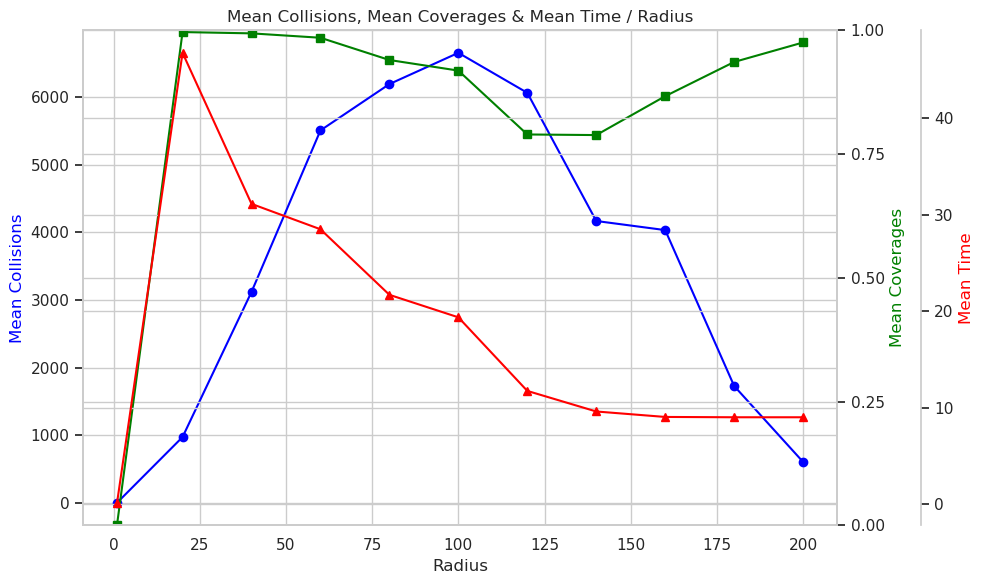

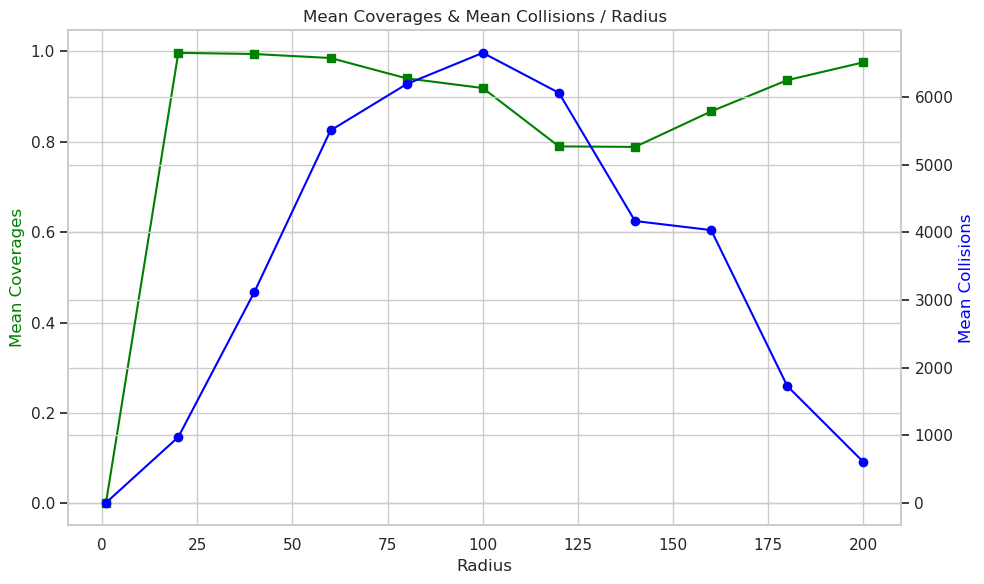

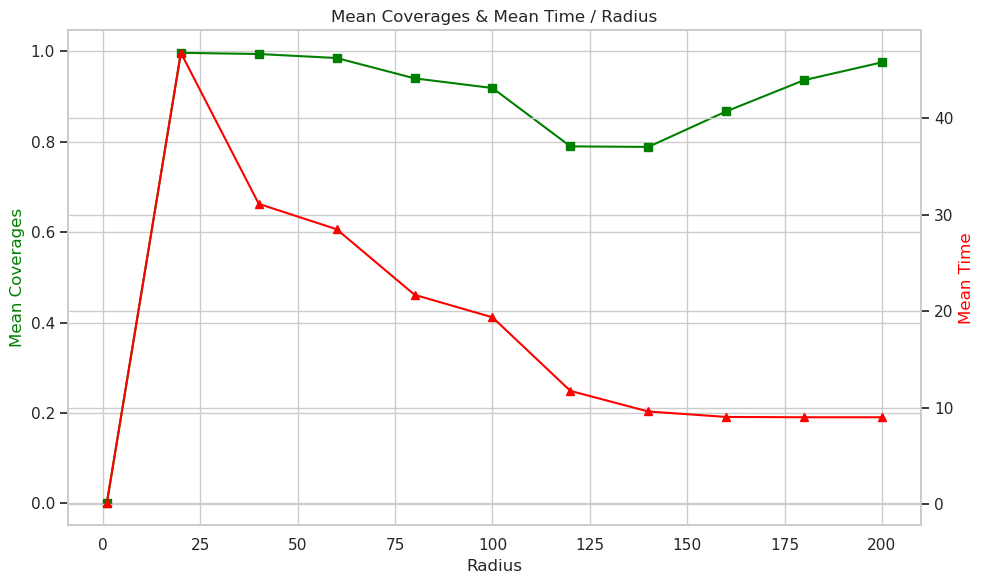

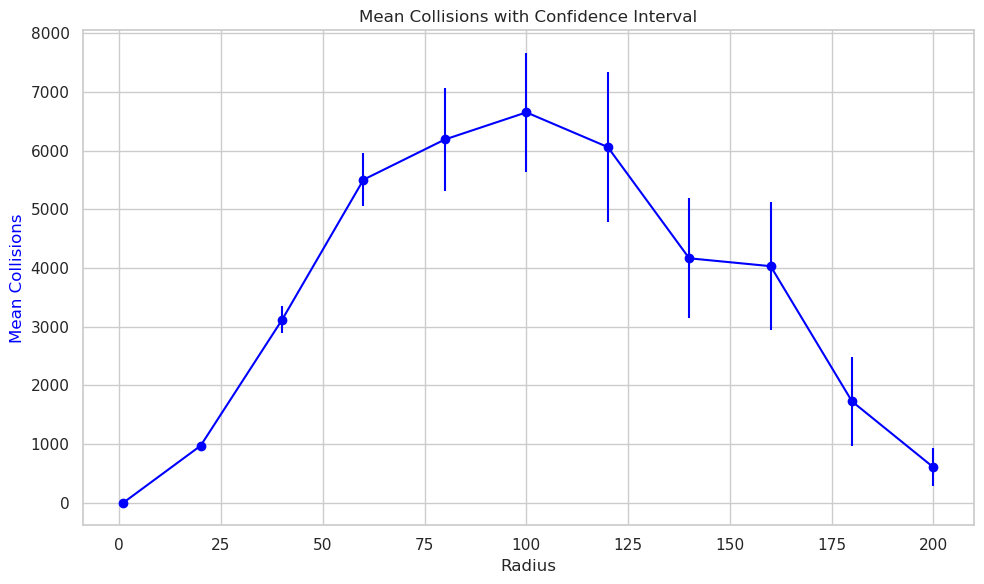

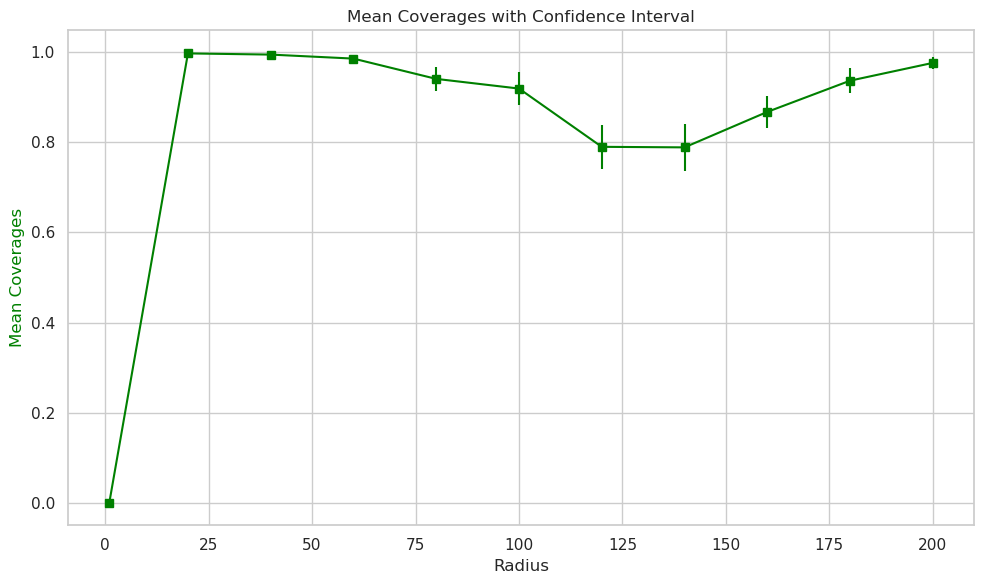

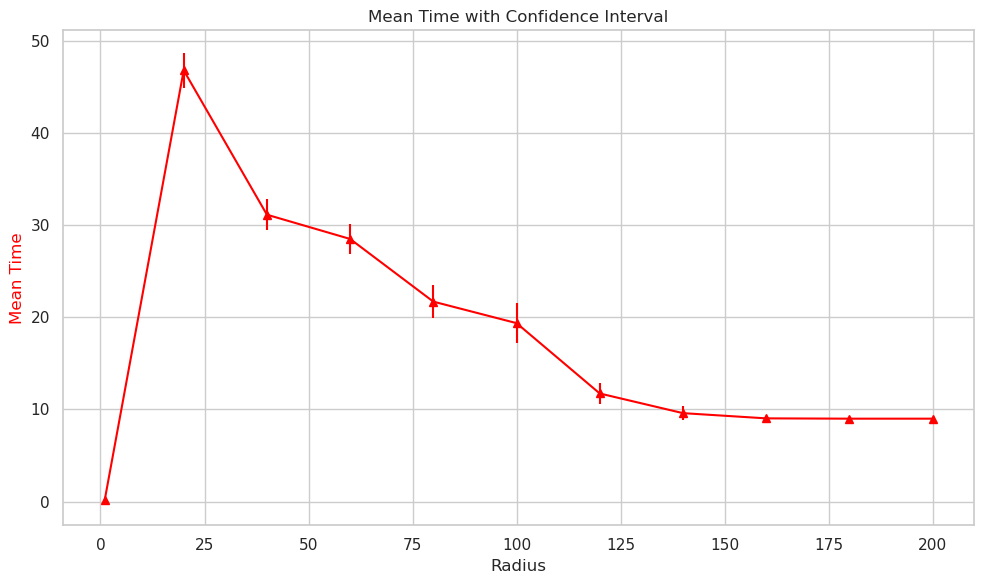

In [900]:
print_graph_radius(os.path.join(depth_cases_path,'midDens_steppedRadius_2'), 30, 11)

#POSITION AND DISTANCE ANALYSIS

In [892]:
name_run = "collisionTest"
repetitions = 100
different_configs = 4
folder_path = os.path.join(stats_path, 'depth')
folder_path = os.path.join(folder_path, name_run)

collisions_vec, coverage_vec = parse_all_files_vec(folder_path, repetitions, different_configs)
collisions_sca, coverages_sca, users, radius, runtimes_sca  = parse_all_files_sca(folder_path, repetitions, different_configs)


coverage_dist = []
sim_coverage_vec = coverage_vec[:2] + coverage_vec[3:]

for i in range(len(sim_coverage_vec)):
    for j in range(len(sim_coverage_vec[i])):
        res = distance_coverage_list(users[i][j], sim_coverage_vec[i][j])
        coverage_dist.extend(res)

/home/enrico/Documents/UNI/performance/EpidemicBroadcast/results/plots


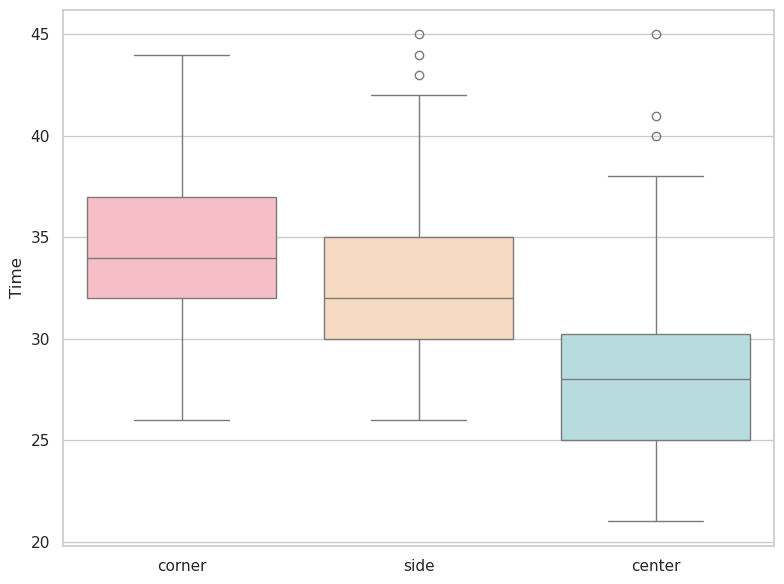

In [893]:
#DESCRIPTION
#Produces boxplot for the test depending on the positionimport matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def draw_boxplot(data, name_list, y_label, save_path):
    plt.figure(figsize=(8, 6))
    sns.set(style='whitegrid')
    colors = ['#FFB6C1', '#FFDAB9', '#B0E0E6']
    sns.boxplot(data=data, palette=colors)
    plt.ylabel(y_label)
    plt.xticks(np.arange(len(data)), name_list)
    plt.tight_layout()
    plt.savefig(save_path,dpi=300)
    plt.show()
    return


names = ["corner", "side", "center"]
os.makedirs(os.path.join(save_path, "collisionsTest"), exist_ok=True)

sim_time = runtimes_sca[:2] + runtimes_sca[3:]
y_label = "Time"
savepath = os.path.join(save_path, "collisionsTest", 'boxplot_times.png')
draw_boxplot(sim_time, names, y_label, savepath)

sim_collisions = collisions_sca[:2] + collisions_sca[3:]
y_label = "Collisions"
savepath = os.path.join(save_path, "collisionsTest", 'boxplot_collisions.png')
draw_boxplot(sim_collisions, names, y_label, savepath)

In [894]:
collision_dist = []
sim_collisions_vec = collisions_vec[:2] + collisions_vec[3:]

curr_user_num = 0
run_user_num = 800

for i in range(len(sim_collisions_vec)):
    for j in range(len(sim_collisions_vec[i])):
        res = distance_collisions_list(users[i][j], sim_collisions_vec[i][j], curr_user_num)
        collision_dist.extend(res)
        curr_user_num += run_user_num
print(len(collision_dist))

collision_dist[:10]

414379


[[1, 185.79148851602434, 0],
 [2, 209.70410279725095, 0],
 [3, 189.45354275125075, 7],
 [4, 150.323582789561, 0],
 [5, 188.02015097486225, 2],
 [5, 188.02015097486225, 2],
 [5, 188.02015097486225, 7],
 [6, 200.2989564842763, 2],
 [7, 184.93159036249054, 0],
 [8, 138.12388327150376, 0]]

/home/enrico/Documents/UNI/performance/EpidemicBroadcast/results/plots


/tmp/ipykernel_9240/3609012972.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='bucket', y='avg_value_per_node', data=grouped, palette='viridis', saturation=1, dodge=False, width=1.0)


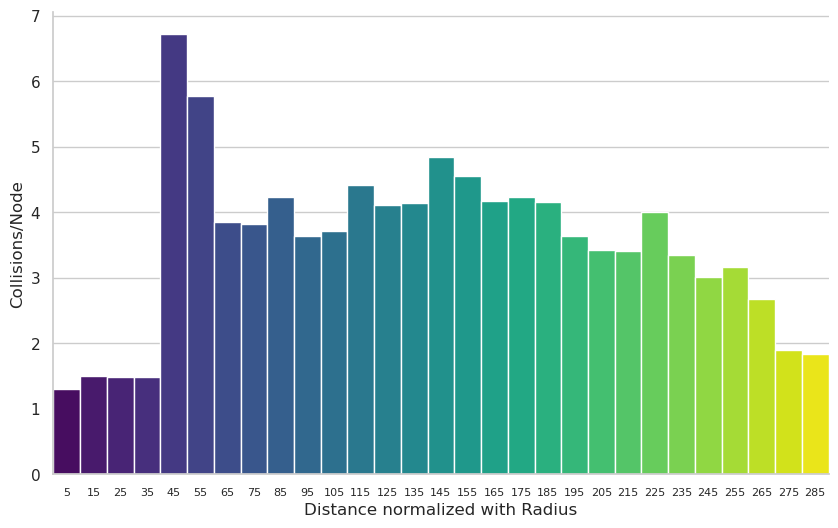

In [895]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_(data, save_path):
    df = pd.DataFrame(data, columns=['node', 'distance', 'value'])
    bucket_size = 10
    
    df['bucket'] = (df['distance'] // bucket_size) * bucket_size
    grouped = df.groupby('bucket').agg({'value': 'sum', 'node': pd.Series.nunique}).reset_index()
    grouped.columns = ['bucket', 'sum_value', 'distinct_nodes']
    grouped['avg_value_per_node'] = grouped['sum_value'] / grouped['distinct_nodes']
    
    
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='bucket', y='avg_value_per_node', data=grouped, palette='viridis', saturation=1, dodge=False, width=1.0)
    sns.despine()
    
    plt.xlabel('Distance normalized with Radius')
    plt.ylabel('Collisions/Node')
    
    # Set x-axis ticks at the midpoints of the bars
    plt.xticks(ticks=np.arange(len(grouped['bucket'])), labels=[f'{int(val)}' for val in grouped['bucket'] + bucket_size / 2], fontsize=8)
    plt.savefig(save_path,dpi=300)
    plt.show()


# Plotting the histogram
print(save_path)
savepath = os.path.join(save_path, "collisionsTest", 'histogram_distance.png')
plot_histogram_(collision_dist, save_path)


<Figure size 1000x600 with 0 Axes>

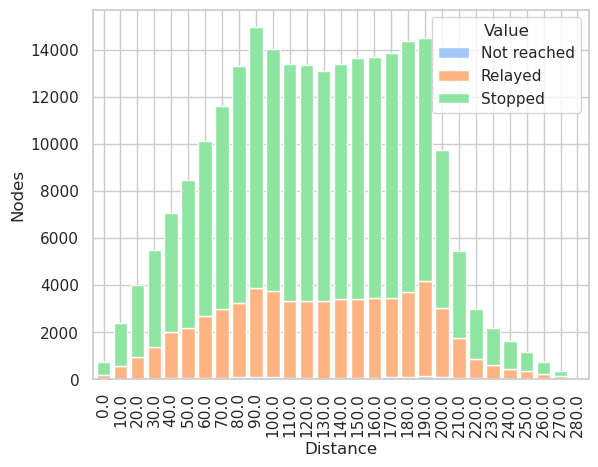

In [896]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_stacked_bar_with_buckets(data, bucket_size, save_path):
    df = pd.DataFrame(data[1:], columns=['Distance', 'Value'])

    # Group distances into buckets
    df['Bucket'] = df['Distance'] // bucket_size * bucket_size

    # Create pivot table with counts of each value in each bucket
    pivot_table = df.pivot_table(index='Bucket', columns='Value', aggfunc='size', fill_value=0)
    pastel_palette = sns.color_palette("pastel", 3)

    # Plotting using pastel colors
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar', stacked=True, width=0.8, color=pastel_palette)
    plt.xlabel('Distance')
    plt.ylabel('Nodes')
    plt.legend(title='Value', labels=['Not reached', 'Relayed', 'Stopped'])
    plt.grid(True)
    plt.savefig(save_path,dpi=300)
    plt.show()


savepath = os.path.join(save_path, "collisionsTest", 'histogram_coverage.png')

create_stacked_bar_with_buckets(coverage_dist, 10, save_path)

<Figure size 1000x600 with 0 Axes>

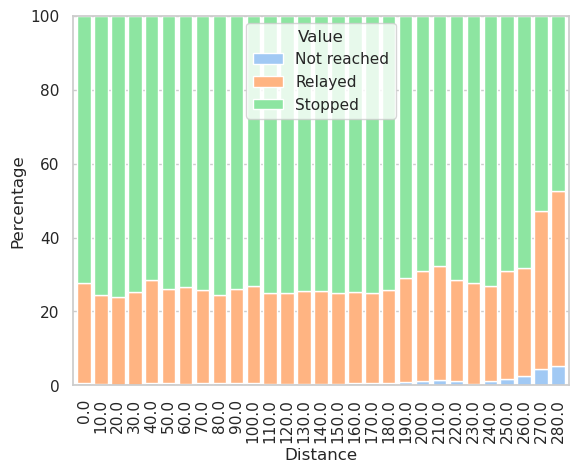

In [897]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_stacked_bar_with_buckets_percentage(data, bucket_size):
    df = pd.DataFrame(data, columns=['Distance', 'Value'])

    # Group distances into buckets
    df['Bucket'] = df['Distance'] // bucket_size * bucket_size

    # Create pivot table with counts of each value in each bucket
    pivot_table = df.pivot_table(index='Bucket', columns='Value', aggfunc='size', fill_value=0)

    # Calculate percentages within each bucket
    pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Define a pastel color palette with three colors for values 0, 1, 2
    pastel_palette = sns.color_palette("pastel", 3)

    # Plotting using pastel colors
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar', stacked=True, width=0.8, color=pastel_palette)
    plt.xlabel('Distance')
    plt.ylabel('Percentage')
    plt.legend(title='Value', labels=['Not reached', 'Relayed', 'Stopped'])
    plt.ylim(0, 100)  # Set y-axis limit to 0-100 for percentages
    plt.grid(True)
    plt.savefig(save_path,dpi=300)
    plt.show()


savepath = os.path.join(save_path, "collisionsTest", 'histogram_coverage_perc.png')

create_stacked_bar_with_buckets_percentage(coverage_dist, 10)